# $M\to\infty$ Transformer

In [97]:
import os
from dotenv import load_dotenv

load_dotenv();

In [98]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from torch.nn import functional as F
from sklearn.manifold import TSNE

# import sys
# del sys.modules['icl.figures.colors']
# del sys.modules['icl.figures.notation']

from icl.analysis.utils import get_unique_run, get_unique_config
from icl.constants import ANALYSIS, FIGURES, SWEEPS
from icl.figures.notation import str_d_dlogt, str_d_dt, str_dlog_dlogt
from icl.figures.colors import plot_transitions, gen_transition_colors, get_transition_type, PRIMARY, SECONDARY, TERTIARY, BRED, BBLUE, BRED, BGREEN
from icl.constants import DEVICE

MODEL_ID = "L2H4Minf-all"
LLC_RUN_ID = "zk7pqalk"  # TODO: Placeholder from m=20

sns.set_style('white')
DEVICE

device(type='mps')

In [99]:
MODEL_SEED = 0
# shorthands
BATCH_SIZE = 8192
K = 8
D = 4

runs = [get_unique_run(
    str(SWEEPS / "training-runs/L2H4Minf.yaml"), 
    task_config={"model_seed": model_seed, "layer_norm": True},
) for model_seed in range(5)]

/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(


In [151]:
from copy import deepcopy 
# Let's generate these same plots and also look at their evolution. 
steps = runs[0].checkpointer.file_ids

all_models = []
all_optimizer_state_dicts = []

for run in tqdm.tqdm(runs):
    models = []
    optimizer_state_dicts = []

    for checkpoint in tqdm.tqdm(run.checkpointer):
        m = deepcopy(run.model)
        m.load_state_dict(checkpoint["model"])
        models.append(m)
        optimizer_state_dicts.append(checkpoint["optimizer"])
        
    all_models.append(models)
    all_optimizer_state_dicts.append(optimizer_state_dicts)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [05:07<00:00, 61.60s/it]


In [ ]:
# Let's look at how the curvature of the llc changes over time. 

import wandb

api = wandb.Api()
llc_run = api.run(f"devinterp/icl/{LLC_RUN_ID}")
history_df = llc_run.history()

llc_mean_columns = [f'llc/mean/{i}' for i in range(8)]
history_df[llc_mean_columns] = history_df[llc_mean_columns].replace("NaN", np.nan)

llc_std_columns = [f'llc/std/{i}' for i in range(8)]
history_df[llc_std_columns] = history_df[llc_std_columns].replace("NaN", np.nan)

# Calculate the average of non-NaN values in llc-chain columns
# and the fraction of NaN values
llc_chain_values = history_df[llc_mean_columns]
mean_llc_chain = llc_chain_values.mean(axis=1, skipna=True)
mean_std_llc_chain = history_df[llc_std_columns].mean(axis=1, skipna=True)
frac_nan = llc_chain_values.isna().mean(axis=1)

history_df["llc/mean"] = mean_llc_chain
history_df["llc/std"] = mean_std_llc_chain
history_df["llc/frac-nan"] = frac_nan
history_df["log_num_tasks"] = 20

# history_df[["llc/mean", "llc/std"]] = history_df[["llc/mean", "llc/std"]].replace("NaN", np.nan)

llc_steps = history_df["_step"]
llcs = history_df["llc/mean"]
llcs_std = history_df["llc/std"]

In [152]:
from icl.analysis.evals import ICLEvaluator

FORCE_REEVAL = False

evaluator = ICLEvaluator(
    pretrain_dist=run.pretrain_dist,
    true_dist=run.true_dist,
    max_examples=run.config.task_config.max_examples,
    eval_batch_size=BATCH_SIZE,
    seed=run.config.task_config.true_seed,   
)

if os.path.exists(ANALYSIS / f"{MODEL_ID}_evals_over_time.csv") and not FORCE_REEVAL:
    print("Loading evals from file")
    evals_over_time_df = pd.read_csv(ANALYSIS / f"{MODEL_ID}_evals_over_time.csv")
    evals_over_time = evals_over_time_df.to_dict("records")
else:
    print("Evaluating models")
    evals_over_time = [{**evaluator(model), "step": step, "model_seed": i} for i, models in enumerate(all_models) for step, model in zip(steps, tqdm.tqdm(models))]
    evals_over_time_df = pd.DataFrame(evals_over_time)
    evals_over_time_df.to_csv(ANALYSIS / f"{MODEL_ID}_evals_over_time.csv")

evals_over_time_df

Evaluating models


 99%|█████████▉| 189/190 [07:36<00:02,  2.42s/it]


,pretrain/mse_subsequence,pretrain/mse_subseq/token/0,pretrain/mse_subseq/token/1,pretrain/mse_subseq/token/2,pretrain/mse_subseq/token/3,pretrain/mse_subseq/token/4,pretrain/mse_subseq/token/5,pretrain/mse_subseq/token/6,pretrain/mse_subseq/token/7,pretrain/mse_subseq,...,true/delta_ridge/token/1,true/delta_ridge/token/2,true/delta_ridge/token/3,true/delta_ridge/token/4,true/delta_ridge/token/5,true/delta_ridge/token/6,true/delta_ridge/token/7,true/delta_ridge,step,model_seed
0,4.226969,4.266549,4.327359,4.230762,4.198189,4.232959,4.274673,4.039577,4.293973,4.233006,...,1.105593,2.040853,2.769002,3.433378,3.819728,3.909074,3.970981,2.648186,0,0
1,4.249811,4.266546,4.327356,4.230762,4.198187,4.232958,4.274672,4.039576,4.293972,4.233004,...,1.105589,2.040852,2.769000,3.433378,3.819725,3.909073,3.970980,2.648184,1,0
2,4.222366,4.266541,4.327352,4.230761,4.198183,4.232956,4.274668,4.039573,4.293969,4.233001,...,1.105584,2.040850,2.768996,3.433376,3.819721,3.909071,3.970978,2.648181,2,0
3,4.249793,4.266536,4.327346,4.230758,4.198177,4.232954,4.274662,4.039570,4.293966,4.232996,...,1.105578,2.040847,2.768992,3.433373,3.819716,3.909068,3.970976,2.648177,3,0
4,4.247118,4.266528,4.327338,4.230755,4.198171,4.232951,4.274656,4.039566,4.293963,4.232991,...,1.105569,2.040843,2.768986,3.433371,3.819710,3.909065,3.970973,2.648172,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,2.768512,4.128078,3.210595,2.342771,1.474388,1.026475,0.742811,0.583446,0.476183,1.748094,...,0.001853,0.008178,0.040086,0.141058,0.182266,0.187919,0.157107,0.089826,479797,4
946,2.763704,4.127987,3.209014,2.339709,1.472101,1.024638,0.742583,0.580827,0.479450,1.747038,...,0.001224,0.007428,0.039987,0.140418,0.181557,0.187779,0.155117,0.089196,484848,4
947,2.811116,4.128260,3.209802,2.339462,1.469967,1.023098,0.738653,0.580421,0.477126,1.745849,...,0.001172,0.007157,0.038734,0.139054,0.180907,0.185156,0.155761,0.088495,489898,4
948,2.730690,4.128015,3.209713,2.338596,1.469810,1.021503,0.740483,0.580351,0.474832,1.745413,...,0.000812,0.006634,0.038178,0.137396,0.181354,0.185309,0.154357,0.088006,494949,4


In [153]:
num_steps = len(steps)
num_steps

190

In [155]:
from icl.figures.derivatives import d_dt, d_dlogt, dlog_dlogt

for i, models in enumerate(all_models):
    for step, model in zip(steps, models):
        evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==i)), "weight/norm"] = (sum(torch.norm(p) ** 2 for p in model.parameters()) ** 0.5).item()
    
    seed_subset = evals_over_time_df[evals_over_time_df.model_seed == i].sort_values("step")

    dw_dts = d_dt(seed_subset['step'].values, seed_subset["weight/norm"].values)
    dw_dlogts = d_dlogt(seed_subset['step'].values, seed_subset["weight/norm"].values)
    dlogw_dlogts = dlog_dlogt(seed_subset['step'].values, seed_subset["weight/norm"].values)

    dL_dts = d_dt(seed_subset['step'].values, seed_subset["pretrain/mse"].values)
    dL_dlogts = d_dlogt(seed_subset['step'].values, seed_subset["pretrain/mse"].values)
    dlogL_dlogts = dlog_dlogt(seed_subset['step'].values, seed_subset["pretrain/mse"].values)

    for step, dw_dt, dw_dlogt, dlogw_dlogt, dL_dt, dL_dlogt, dlogL_dlogt in zip(seed_subset['step'], dw_dts, dw_dlogts, dlogw_dlogts, dL_dts, dL_dlogts, dlogL_dlogts):
        evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==i)), "weight/norm/d_dt"] = dw_dt
        evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==i)), "weight/norm/d_dlogt"] = dw_dlogt
        evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==i)), "weight/norm/dlog_dlogt"] = dlogw_dlogt
        evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==i)), "pretrain/mse/d_dt"] = dL_dt
        evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==i)), "pretrain/mse/d_dlogt"] = dL_dlogt
        evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==i)), "pretrain/mse/dlog_dlogt"] = dlogL_dlogt

In [ ]:
evals_over_time_df.columns

Index(['pretrain/mse_subsequence', 'pretrain/mse_subseq/token/0',
       'pretrain/mse_subseq/token/1', 'pretrain/mse_subseq/token/2',
       'pretrain/mse_subseq/token/3', 'pretrain/mse_subseq/token/4',
       'pretrain/mse_subseq/token/5', 'pretrain/mse_subseq/token/6',
       'pretrain/mse_subseq/token/7', 'pretrain/mse_subseq',
       'pretrain/mse/token/0', 'pretrain/mse/token/1', 'pretrain/mse/token/2',
       'pretrain/mse/token/3', 'pretrain/mse/token/4', 'pretrain/mse/token/5',
       'pretrain/mse/token/6', 'pretrain/mse/token/7', 'pretrain/mse',
       'pretrain/delta_dmmse/token/0', 'pretrain/delta_dmmse/token/1',
       'pretrain/delta_dmmse/token/2', 'pretrain/delta_dmmse/token/3',
       'pretrain/delta_dmmse/token/4', 'pretrain/delta_dmmse/token/5',
       'pretrain/delta_dmmse/token/6', 'pretrain/delta_dmmse/token/7',
       'pretrain/delta_dmmse', 'pretrain/delta_ridge/token/0',
       'pretrain/delta_ridge/token/1', 'pretrain/delta_ridge/token/2',
       'pretrain/de

In [ ]:
steps

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 14,
 16,
 18,
 21,
 24,
 27,
 31,
 35,
 40,
 46,
 53,
 60,
 69,
 79,
 90,
 103,
 118,
 134,
 153,
 175,
 200,
 229,
 261,
 298,
 341,
 389,
 444,
 507,
 579,
 661,
 755,
 862,
 984,
 1124,
 1283,
 1465,
 1673,
 1910,
 2181,
 2490,
 2843,
 3247,
 3707,
 4232,
 4832,
 5050,
 5517,
 6299,
 7192,
 8211,
 9375,
 10101,
 10704,
 12221,
 13954,
 15151,
 15932,
 18190,
 20202,
 20768,
 23711,
 25252,
 27072,
 30303,
 30909,
 35290,
 35353,
 40292,
 40404,
 45454,
 46003,
 50505,
 52524,
 55555,
 59968,
 60606,
 65656,
 68468,
 70707,
 75757,
 78172,
 80808,
 85858,
 89252,
 90909,
 95959,
 101010,
 101902,
 106060,
 111111,
 116161,
 116345,
 121212,
 126262,
 131313,
 132836,
 136363,
 141414,
 146464,
 151515,
 151663,
 156565,
 161616,
 166666,
 171717,
 173159,
 176767,
 181818,
 186868,
 191919,
 196969,
 197702,
 202020,
 207070,
 212121,
 217171,
 222222,
 225724,
 227272,
 232323,
 237373,
 242424,
 247474,
 252525,
 257575,
 257717,
 

In [199]:
import colorsys
from matplotlib.colors import LinearSegmentedColormap


# TRANSITIONS = [
#     (30, 1200, 'A1'),
#     (1200, 12500, 'A2'),
#     (12500, 60000, 'B1'),
#     (60000, 110000, 'B2'),
#     (110000, 180000, 'B3'),
#     (180000, 280000, "B4"),
#     (280000, 320000, "B5"),
#     (320000, 500000, "B6")
# ]


TRANSITIONS = [
    # PCA-based
    # (0, 600, 'A1a'),
    # (600, 2000, 'A1b'),
    # (2000, 3000, 'A2a'),
    # (3000, 15000, 'A2b'),
    # (15000, 28000, 'B1a'),
    # (28000, 60000, 'B1b'),
    # (60000, 140000, 'B2a'),
    # (140000, 500000, 'B2b'),
    # LLC-based
    (0, 500, 'A1a'),
    (500, 1200, 'A1b'),
    (1200, 3200, 'A2a'),
    (3200, 9000, 'A2b'),
    (9000, 28000, 'B1a'),
    (28000, 60000, 'B1b'),
    (60000, 120000, 'B2a'),
    (120000, 500000, 'B2b'),
    # (110000, 180000, 'B3'),
    # (180000, 280000, "B4"),
    # (280000, 320000, "B5"),
    # (320000, 500000, "B6")
]

# def gen_transition_colors(types):
#     """Generates a palette for transition colors. Orange-flavored for Type A. Blue-flavored for Type B."""
#     num_type_a = sum([t == "A" for t in types])
#     num_type_b = sum([t == "B" for t in types])
#     num_other = sum([t == "Other" for t in types])

#     type_a_palette = sns.color_palette("Oranges_r", num_type_a)
#     type_b_palette = sns.color_palette("Blues_r", num_type_b)
#     other_palette = sns.color_palette("Greys_r", num_other)

#     palette = []

#     for t in types:
#         if t == "A":
#             palette.append(type_a_palette.pop())
#         elif t == "B":
#             palette.append(type_b_palette.pop())
#         else:
#             palette.append(other_palette.pop())

#     return palette


def increase_saturation(rgb, saturation_factor):
    # Convert RGB to HSV
    hsv = colorsys.rgb_to_hsv(*rgb)
    
    # Increase saturation by the given factor, making sure it stays in [0, 1]
    new_s = min(max(hsv[1] * saturation_factor, 0), 1)
    
    # Convert back to RGB
    new_rgb = colorsys.hsv_to_rgb(hsv[0], new_s, hsv[2])
    return new_rgb


def increase_contrast(rgb, contrast_factor):
    # Midpoint
    midpoint = 128.0 / 255
    
    # Increase contrast
    new_rgb = [(0.5 + contrast_factor * (component - 0.5)) for component in rgb]
    
    # Clip to the range [0, 1]
    new_rgb = [min(max(component, 0), 1) for component in new_rgb]
    return new_rgb



transition_types = [get_transition_type(t) for t in TRANSITIONS]
transition_colors = gen_transition_colors(transition_types)

transition_colors = [increase_saturation(rgb, 2) for rgb in transition_colors]
transition_colors = [increase_contrast(rgb, 2) for rgb in transition_colors]

transitions_cmap = LinearSegmentedColormap.from_list("transitions", transition_colors)

In [206]:
import matplotlib.pyplot as plt
import os
from typing import Optional

def get_transition_indices(steps, transitions):
    transition_indices = []
    for step in steps:
        # Find the index of the transition that the current step falls into
        index = next((i for i, transition in enumerate(transitions) if transition[0] <= step < transition[1]), None)
        transition_indices.append(index if index is not None else -1)

    return transition_indices

def get_nearest_step(step):
    idx = np.argmin(np.abs(np.array(steps) - step))
    return steps[idx]


transitions_of_steps = get_transition_indices(steps, TRANSITIONS)
highlight_steps = list(map(get_nearest_step, [t[0] for t in TRANSITIONS][1:]))

highlight_steps

[507, 1124, 3247, 9375, 27072, 59968, 121212]

/Users/Jesse/Projects/icl/icl/figures/colors.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)


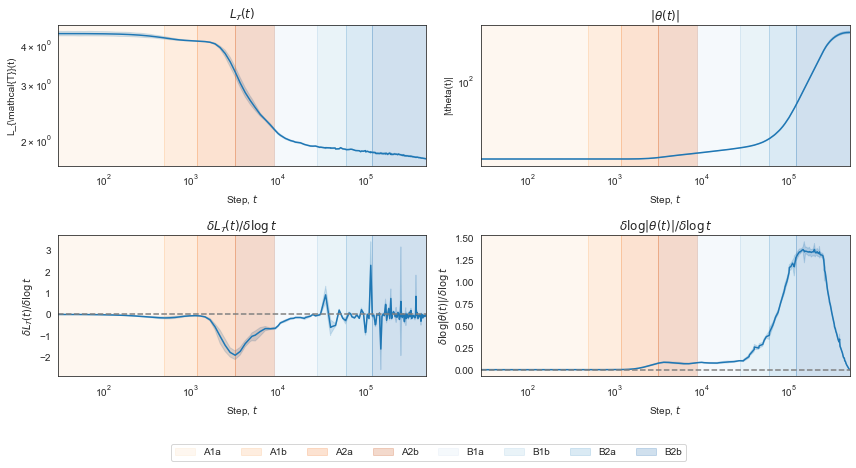

In [200]:
metrics_to_plot = [
    (r"L_{\mathcal{T}}(t)", "pretrain/mse", {"logy": True}, ),
    # (r"L_\mathcal{G}(t)", evals_over_time_df["true/mse"], {"logy": False}),
    # (r"\hat \lambda(t)", llcs, {}),
    (r"|\theta(t)|", "weight/norm", {"derivative": "dlog_dlogt", "logy": True}),
] 

fig, axes = plt.subplots(2, len(metrics_to_plot), figsize=(12, 6))

# axes = np.array(axes)
axes = axes.reshape(2, len(metrics_to_plot))

for i, (metric_name, metric_key, kwargs) in enumerate(metrics_to_plot):
    sns.lineplot(data=evals_over_time_df, x="step", y=evals_over_time_df[metric_key], ax=axes[0, i],label=metric_name)
    # axes[0, i].plot(evals_over_time_df['step'], metric_values, label=metric_name, marker='.')
    axes[0, i].set_title(f"${metric_name}$")
    axes[0, i].set_xlabel('Step, $t$')
    axes[0, i].set_ylabel(metric_name)

    if kwargs.get("logy", False):
        axes[0, i].set_yscale('log')

    axes[0, i].legend().remove()

    slope_type = kwargs.get("derivative", "d_dlogt")

    if slope_type == "d_dlogt":
        slope_name = str_d_dlogt(metric_name)
    elif slope_type == "d_dt":
        slope_name = str_d_dt(metric_name)
    elif slope_type == "dlog_dlogt":
        slope_name = str_dlog_dlogt(metric_name)
    else:
        raise ValueError(f"Unknown slope type {slope_type}")

    sns.lineplot(data=evals_over_time_df, x="step", y=f"{metric_key}/{slope_type}", ax=axes[1, i], label=metric_name + " Slope", )
    axes[1, i].axhline(0, linestyle='--', color='gray')
    axes[1, i].set_title(slope_name)
    axes[1, i].set_xlabel('Step, $t$')
    axes[1, i].set_ylabel(slope_name)
    axes[1, i].legend().remove()

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(30, 500_000)


# axes[0, 1].set_ylim(0, 100)
# axes[1, 1].set_ylim(0, 200)
# axes[1,1].set_ylim(-2, 2)

patch_list = plot_transitions(axes, TRANSITIONS, limit=True)

# axes[1, 1].set_yscale('symlog')
# axes[1,0].set_yscale('symlog')
# axes[0,0].set_ylim(0, 70)

milestone_labels = [label for _, _, label in TRANSITIONS]
fig.legend(patch_list, milestone_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS))

fig.set_facecolor("white")
fig.tight_layout()

# Behavioral Indicators

In [ ]:
len(all_models), len(runs)

(1, 5)

## Loss, Prediction Norm, OOD Loss

In [158]:
# Wait if my layer norm theory is right. Then we should see a sudden improvement in the ability of the model to make predictions for out-of-distribution xs/ys (not ws). 
from devinfra.utils.seed import set_seed
from icl.tasks import apply_transformations
from devinfra.utils.iterables import flatten_dict

def eval_loss(yhats, ys):
    losses = ((yhats - ys) ** 2).mean(dim=0)[:, 0]
    return np.array([loss.item() for loss in losses] + [losses.mean().item()])

OOD_MULTIPLIER = 3

for seed, (run, models) in enumerate(zip(runs, all_models)):
    print(f"Seed {seed}")
    # sample a batch of random tasks
    ws = run.pretrain_dist.task_distribution.sample_tasks(BATCH_SIZE) # -> B D

    # sample i.i.d. inputs and outputs for each task according to the
    # regression model
    xs = torch.normal(
        mean=0.,
        std=1.,
        size=(BATCH_SIZE, K, D,),
        device=DEVICE
    )

    ood_xs = OOD_MULTIPLIER * xs
    ys = apply_transformations(ws, xs, 0.125, DEVICE)
    ood_ys = apply_transformations(ws, ood_xs, 0.125, DEVICE)

    first_xs = xs[:, 0:1, :]
    first_xs /= torch.norm(first_xs, dim=-1, keepdim=True)
    ys_using_first_x = apply_transformations(first_xs, xs, 0.125, DEVICE)
    
    for step, model in tqdm.tqdm(zip(steps, models), total=len(steps)):
        losses = eval_loss(model(xs, ys), ys)
        ood_losses = eval_loss(model(ood_xs, ood_ys), ood_ys)
        losses_0s = eval_loss(model(xs, ys), torch.zeros_like(ys))
        losses_first_xs = eval_loss(model(xs, ys), ys_using_first_x)

        for i in range(9):
            evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==seed)), f"loss/{i}"] = losses[i]
            evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==seed)), f"ood_loss/{i}"] = ood_losses[i]
            evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==seed)), f"loss_0/{i}"] = losses_0s[i]
            # evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==seed)), f"loss_first_x/{i}"] = losses_first_xs[i]
            
        evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==seed)), "loss/mean"] = np.mean(losses)
        evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==seed)), "ood_loss/mean"] = np.mean(ood_losses)
        evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==seed)), "loss_0/mean"] = np.mean(losses_0s)
        # evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==seed)), "loss_first_x/mean"] = np.mean(losses_first_xs[1:])


Seed 0


100%|██████████| 190/190 [00:28<00:00,  6.60it/s]


Seed 1


100%|██████████| 190/190 [00:28<00:00,  6.61it/s]


Seed 2


100%|██████████| 190/190 [00:28<00:00,  6.71it/s]


Seed 3


100%|██████████| 190/190 [00:28<00:00,  6.74it/s]


Seed 4


100%|██████████| 190/190 [00:28<00:00,  6.75it/s]


In [ ]:
evals_over_time_df.columns.values

In [ ]:
evals_over_time_df.loc[(evals_over_time_df.model_seed==2), "loss/2"]

380    4.187860
381    4.187859
382    4.187857
383    4.187854
384    4.187850
         ...   
565    2.035680
566    2.037914
567    2.041246
568    2.036952
569    2.038740
Name: loss/2, Length: 190, dtype: float64

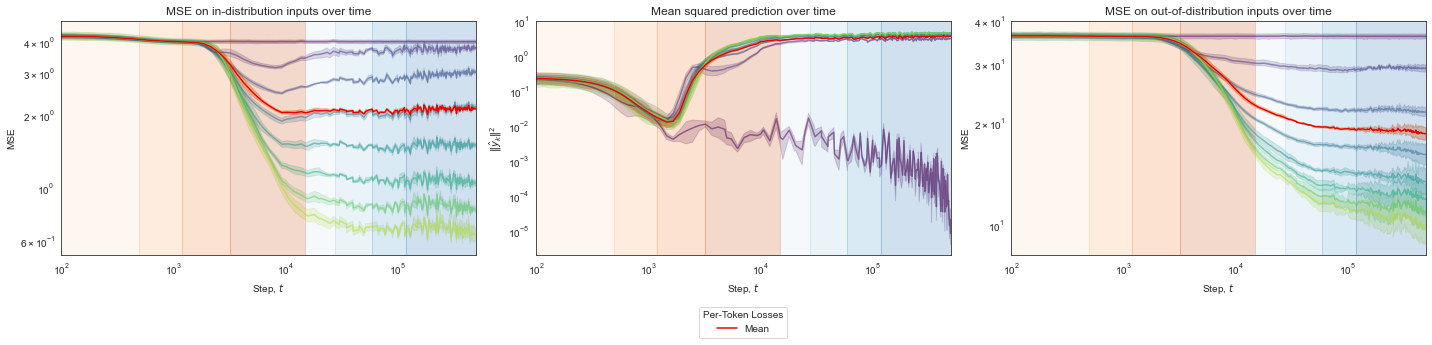

In [195]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

token_cmap = ScalarMappable(norm=Normalize(vmin=0, vmax=8), cmap="viridis")

for i in range(9):
    color = token_cmap.to_rgba(i)
    sns.lineplot(data=evals_over_time_df, x="step", y=f"loss/{i}", ax=axes[0], alpha=0.5, color=color)
    sns.lineplot(data=evals_over_time_df, x="step", y=f"loss_0/{i}", ax=axes[1], alpha=0.5, color=color)
    sns.lineplot(data=evals_over_time_df, x="step", y=f"ood_loss/{i}", ax=axes[2], alpha=0.5, color=color)
    # if i > 0:
    #     sns.lineplot(data=evals_over_time_df, x="step", y=f"loss_first_x/{i}", ax=axes[2], alpha=0.5, color=color)

sns.lineplot(data=evals_over_time_df, x="step", y="loss/mean", label="Mean", ax=axes[0], color=BRED)
sns.lineplot(data=evals_over_time_df, x="step", y="loss_0/mean", label="Mean", ax=axes[1], color=BRED)
# sns.lineplot(data=evals_over_time_df, x="step", y="loss_first_x/mean", label="Mean", ax=axes[2], color=BRED)
sns.lineplot(data=evals_over_time_df, x="step", y="ood_loss/mean", label="Mean", ax=axes[2], color=BRED)

for ax in axes:
    ax.set_xscale("log")
    ax.set_xlabel("Step, $t$")
    ax.set_yscale('log')
    legend = ax.legend()
    legend.remove()
    ax.set_xlim(100, 500_000)

legend = axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=6)
legend.set_title("Per-Token Losses")

# Move legend to be likee fig.legend(patch_list, milestone_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS))

axes[0].set_title("MSE on in-distribution inputs over time")
axes[0].set_ylabel("MSE")

axes[1].set_title("Mean squared prediction over time")
axes[1].set_ylabel(r"$\|\hat y_k\|^2$")

axes[2].set_title("MSE on out-of-distribution inputs over time")
axes[2].set_ylabel("MSE")

plot_transitions(axes, TRANSITIONS)

for ax in axes:
    ax.set_xscale('log')

plt.tight_layout()
# Add color bar on the far right

fig.set_facecolor('white')

## In-context learning score

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/Jesse/Projects/icl/icl/figures/colors.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)
<ipython-input-164-2fa3d35e833f>:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


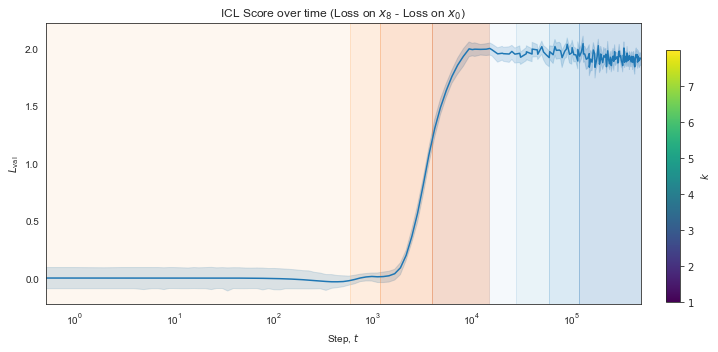

In [164]:
from matplotlib import colors as mcolors

LINE_PALETTE="viridis"
ALPHA=1

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

icl_score = - evals_over_time_df["loss/8"].values + evals_over_time_df["loss/0"].values
sns.lineplot(x=evals_over_time_df.step, y=icl_score, alpha=ALPHA, ax=ax)
    
# ax.set_yscale('log')
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$L_\mathrm{val}$")
ax.legend().remove()
ax.set_title("ICL Score over time (Loss on $x_8$ - Loss on $x_0$)")

plot_transitions(ax, TRANSITIONS, limit=True) #, alpha=0.25)

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust as necessary for position and size

# custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=1, vmax=8), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = range(1, len(LINE_PALETTE)+1)  # Positions for each color
tick_labels = [f"${i}$" for i in range(1, len(LINE_PALETTE) + 1)] # Replace with your labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$k$")

plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


## Behavioral Essential Dynamics

In [172]:
# Do the PCAs again. 
from typing import Dict, Iterable, Tuple
from sklearn.decomposition import PCA
from collections import defaultdict
from devinterp.mechinterp.hooks import hook
import numpy as np
from icl.analysis.utils import map_evals_over_checkpoints, get_unique_run
from icl.train import Run
from devinfra.utils.tensors import convert_tensor, ReturnTensor
from matplotlib import colors as mcolors


def extract_activations_over_checkpoints(models: Iterable[nn.Module], xs, ys, *paths, return_type: ReturnTensor="np"):
    def eval_activations(model):
        model.to(DEVICE)
        xs.to(model.device)
        ys.to(model.device)
        hooked_model = hook(model, *paths)
        outputs, activations = hooked_model.run_with_cache(xs, ys)
        activations[""] = outputs
        return {k: convert_tensor(v, return_type) for k, v in activations.items() if (k in paths or k == "") and v is not None}
    
    for model in models:
        yield eval_activations(model)


def get_vectorized_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, normalize=False):
    evals: Dict[str, list] = defaultdict(list)
    
    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths):
        for path, activation in activations.items():
            if normalize:
                activation = activation / np.linalg.norm(activation)

            evals[path].append(activation)

    return {
        k: np.array(v).reshape(len(v), -1) for k, v in evals.items()
    }

def get_pca_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, num_components=3, normalize=False) -> Dict[str, Tuple[PCA, np.ndarray]]:
    results = {}

    for path, activations in get_vectorized_activations_trace(models, xs, ys, *paths, normalize=normalize).items():
        pca = PCA(n_components=num_components)
        activations_reduced = pca.fit_transform(activations)
        results[path] = pca, activations_reduced

    return results


tab10 = plt.cm.get_cmap('tab10', 10)  # Get the tab10 colormap
colors = tab10.colors[:len(TRANSITIONS)]  # Get the first 6 colors 
# Add an extra gray to this np array for extra colors
colors = np.vstack((colors, np.array([0.8, 0.8, 0.8, 1.0])))

# Create a new colormap from the extracted colors
custom_cmap = mcolors.ListedColormap(colors)

# plot_multiple_slices(steps, demo_logits_reduced_3, demo_logits_pca_3, title=demo.config.to_latex(), connect_dots=True)
train_xs_1, train_ys_1 = runs[0].pretrain_dist.get_batch(8, 1024)

traces = get_pca_activations_trace(
    all_models[0],
    train_xs_1, 
    train_ys_1, 
    "token_sequence_transformer",
    # "token_sequence_transformer.blocks.1",
    # "token_sequence_transformer.token_embedding",
    num_components=10,
    normalize=False
) 

# traces_small = get_pca_activations_trace(
#     models,
#     train_xs_1[:1024], 
#     train_ys_1[:1024], 
#     "",
#     "token_sequence_transformer.blocks.1",
#     # "token_sequence_transformer.token_embedding",
#     num_components=3,
#     normalize=False
# ) 

pca_outputs, logits_outputs = traces[""]
pca_logits, logits_reduced = traces["token_sequence_transformer"]
# pca_internal, activations_reduced = traces_small["token_sequence_transformer.blocks.1"]

traces_normalized = get_pca_activations_trace(
    all_models[0],
    train_xs_1, 
    train_ys_1, 
    "token_sequence_transformer",
    # "token_sequence_transformer.blocks.1",
    # "token_sequence_transformer.token_embedding",
    num_components=10,
    normalize=True
) 

# traces_small_normalized = get_pca_activations_trace(
#     models,
#     train_xs_1[:1024], 
#     train_ys_1[:1024], 
#     # "token_sequence_transformer",
#     "token_sequence_transformer.blocks.1",
#     # "token_sequence_transformer.token_embedding",
#     num_components=3,
#     normalize=True
# ) 

pca_outputs_normalized, activations_outputs_normalized = traces_normalized[""]
pca_internal_normalized, activations_reduced_normalized = traces_normalized["token_sequence_transformer"]
# pca_internal, activations_reduced = traces_small["token_sequence_transformer.blocks.1"]

<ipython-input-172-64de05143fe4>:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = plt.cm.get_cmap('tab10', 10)  # Get the tab10 colormap


In [188]:

def plot_explained_variance(pca, title="Explained Variance", ax: Optional[plt.Axes] = None, num_pca_components=None):
    num_pca_components = num_pca_components or len(pca.explained_variance_ratio_)

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(range(num_pca_components), pca.explained_variance_ratio_[:num_pca_components])

    for i, ratio in enumerate(pca.explained_variance_ratio_[:num_pca_components]):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha='center', va='bottom')

    ax.set_title(title)
    ax.set_xlabel('PC')
    ax.set_ylabel('Explained Variance')

    ax.set_xticks(range(num_pca_components), range(1, num_pca_components + 1))


def plot_multiple_slices(steps, samples, pca, transitions, highlighted_steps=None, connect_dots=False, palette='tab10', alpha=0.8, save=False, line_color="auto", figsize=(20, 4)):
    transition_idxs = get_transition_indices(steps, transitions)
    # transition_idxs = [(0 if i != 4 else 1) for i in transition_idxs]

    # for i in range(1, 5):
    #     transition_idxs[-i] = 10  

    if highlighted_steps is None:
        highlighted_steps = list(map(get_nearest_step, [t[0] for t in transitions][1:]))

    num_pca_components = samples.shape[-1]
    
    # Create a single row of subplots
    num_pca_combos = (num_pca_components * (num_pca_components-1)) // 2
    
    fig, axes = plt.subplots(1, num_pca_combos + 1, figsize=figsize)
    # fig.suptitle(title)

    # Ensure ax is iterable by converting to a list if there's only one subplot
    if num_pca_components == 2:
        axes = [axes]

    I = 0
    for i in range(1, num_pca_components):
        for j in range(i):

            if connect_dots:
                axes[I].plot(samples[:, i], samples[:, j], c='black', alpha=0.2)

            # sc = axes[I].scatter(samples[:, i], samples[:, j], c=transition_idxs, cmap=cmap, s=50, alpha=alpha)
            sns.scatterplot(x=samples[:, i], y=samples[:, j], hue=transition_idxs, palette=palette, s=50, alpha=alpha, ax=axes[I], legend=False)
            axes[I].set_xlabel(f'PC {i}')
            axes[I].set_ylabel(f'PC {j}')
            axes[I].set_title(f'PC {i} vs PC {j}')

            # Label some points
            total_samples = len(samples)
            for step in highlighted_steps:
                k = steps.index(step)  # Find the index of the highlighted step
                axes[I].text(samples[k, i], samples[k, j], str(step), fontsize=8, ha='right', va='bottom', alpha=0.8)

            I += 1

    plot_explained_variance(pca, ax=axes[-1], num_pca_components=num_pca_components)
    # for I in range( num_pca_combos):
    #     axes[I].axis('off')
            
    # Colorbar for the last plot
    # cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as necessary
        # plt.colorbar(sc, cax=cbar_ax, label='Milestones')

    cmap = sns.palettes.color_palette(palette, n_colors=len(transitions) + 1)

    # Plot the legend on the first subplot on the left
    legend_ax = axes[0]
    scatter_proxy = [plt.Line2D([0], [0], linestyle='none', marker='o', alpha=alpha, color=cmap[i]) for i in range(len(transitions))]
    legend_labels = [label for _, _, label in transitions]
    legend_ax.legend(scatter_proxy, legend_labels, loc='center', ncol=1, frameon=False, bbox_to_anchor=(-0.5, 0.5), title='Developmental Stages')
    # legend_ax.set_title()

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right side to make room for the colorbar

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


    fig.set_facecolor('white')
    
# Usage of the function
# Call the function with your data and the list of highlighted steps
# plot_multiple_slices(steps, samples, pca, highlighted_steps=[100, 1000, 10000], title="Your Title", num_points_to_label=10, save="path/to/save.png", connect_dots=True)

<ipython-input-202-d4ae132ea7d4>:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


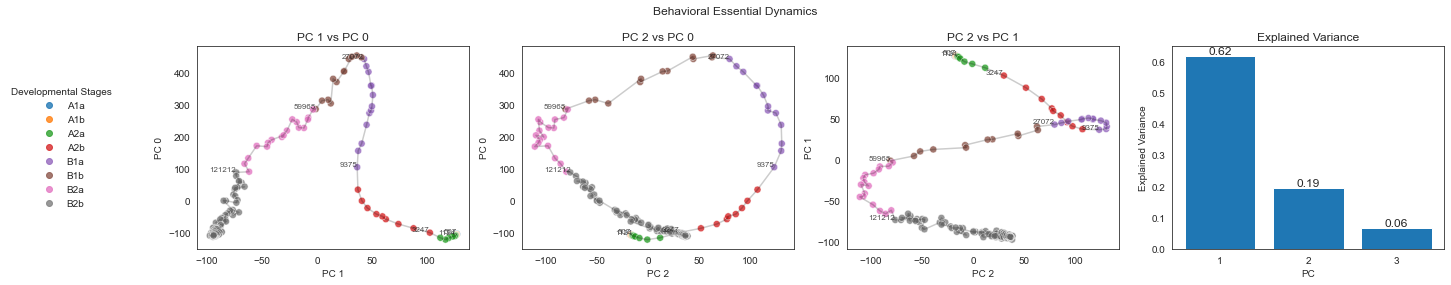

<ipython-input-202-d4ae132ea7d4>:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


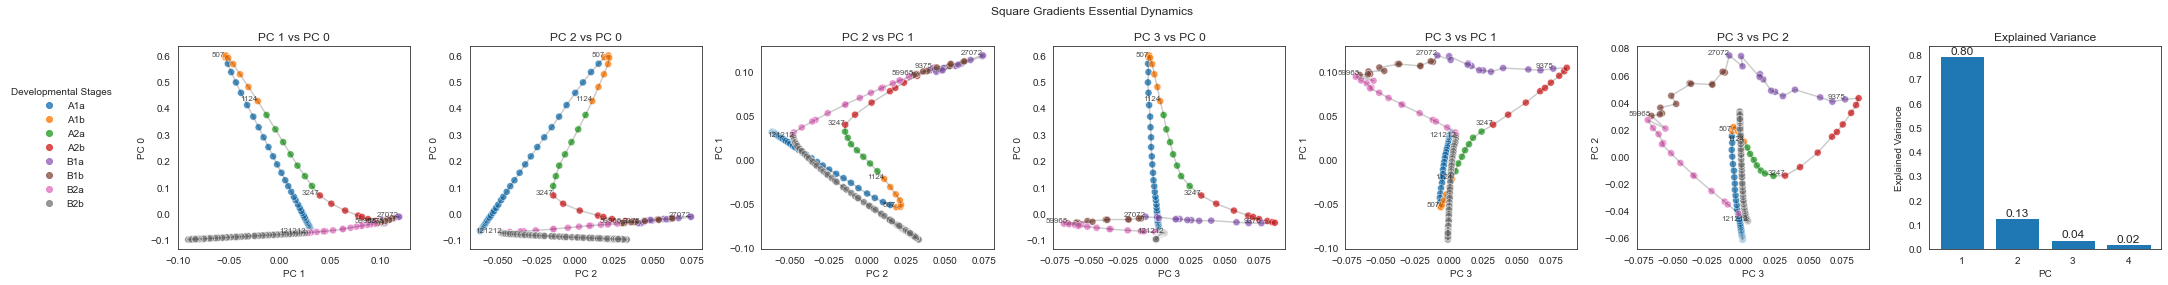

In [202]:
plot_multiple_slices(
    steps, 
    logits_reduced[:, :3], 
    pca_logits, 
    TRANSITIONS,
    connect_dots=True, 
    save=None,
    # cmap=transitions_cmap
)
plt.suptitle("Behavioral Essential Dynamics")
plt.tight_layout()
plt.show()

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced[:, :4], 
    pca_1, 
    TRANSITIONS,
    connect_dots=True, 
    save=None,
    figsize=(30, 4)
    # cmap=transitions_cmap
)
plt.suptitle("Square Gradients Essential Dynamics")
plt.tight_layout()
plt.show()


# Geometric Indicators

## Gradients

In [176]:
from torch.nn import functional as F

run0, models0 = runs[0], all_models[0]

gradient_stats = []

xs, ys = run0.evaluator.pretrain_xs, run0.evaluator.pretrain_ys
xs, ys = xs.to(DEVICE), ys.to(DEVICE)


for step, model in zip(steps, models0):
    model.to(DEVICE)
    model.zero_grad()

    yhats = model(xs, ys)

    loss = F.mse_loss(yhats, ys)
    loss.backward()

    for n, p in model.named_parameters():

        if p.grad is None:
            continue

        grad_sq_mean = (p.grad ** 2).mean().item()
        grad_sq_std = (p.grad ** 2).std().item()

        gradient_stats.append({
            "step": step,
            "layer": n,
            "grad/norm": grad_sq_mean ** 0.5,
            "grad_sq/mean": grad_sq_mean,
            "grad_sq/std": grad_sq_std,
            "numel": p.numel(),
            "loss": loss.item(),
        })          

        p.grad = None 

gradient_stats = pd.DataFrame(gradient_stats)

<ipython-input-177-098f67ac9b25>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_gradients = gradient_stats.groupby(['step']).mean()
/Users/Jesse/Projects/icl/icl/figures/colors.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)


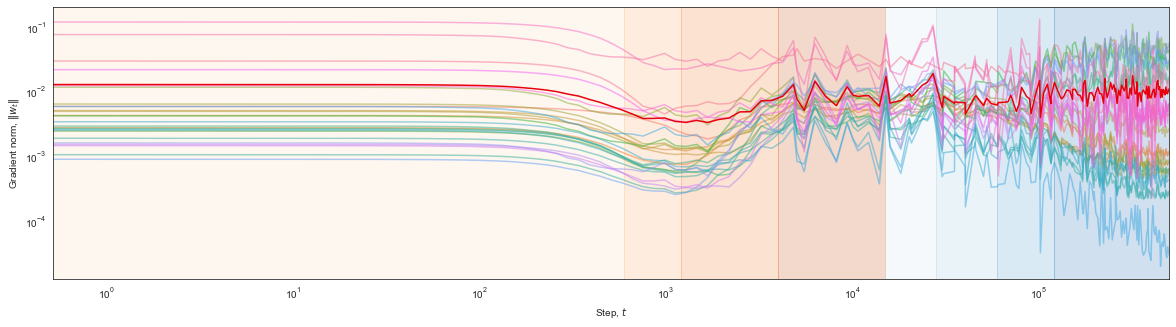

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

avg_gradients = gradient_stats.groupby(['step']).mean()

grad_norm_thresholded = gradient_stats['grad/norm'].values + 0.00001

sns.lineplot(data=gradient_stats, x='step', y=grad_norm_thresholded, hue="layer", ax=ax, legend=False, alpha=0.5)
sns.lineplot(data=avg_gradients, x='step', y='grad/norm', ax=ax, legend=False, color=BRED)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Step, $t$")
ax.set_ylabel("Gradient norm, $\|w_t\|$")

_ = plot_transitions(ax, TRANSITIONS, limit=True)


<ipython-input-178-283e9350a379>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_optimizer_stats = optimizer_stats.groupby('step').mean()
<ipython-input-178-283e9350a379>:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=avg_optimizer_stats, x="step", y="exp_avg_sq_norm", palette="viridis", ax=ax, color=BRED)


(100, 500000)

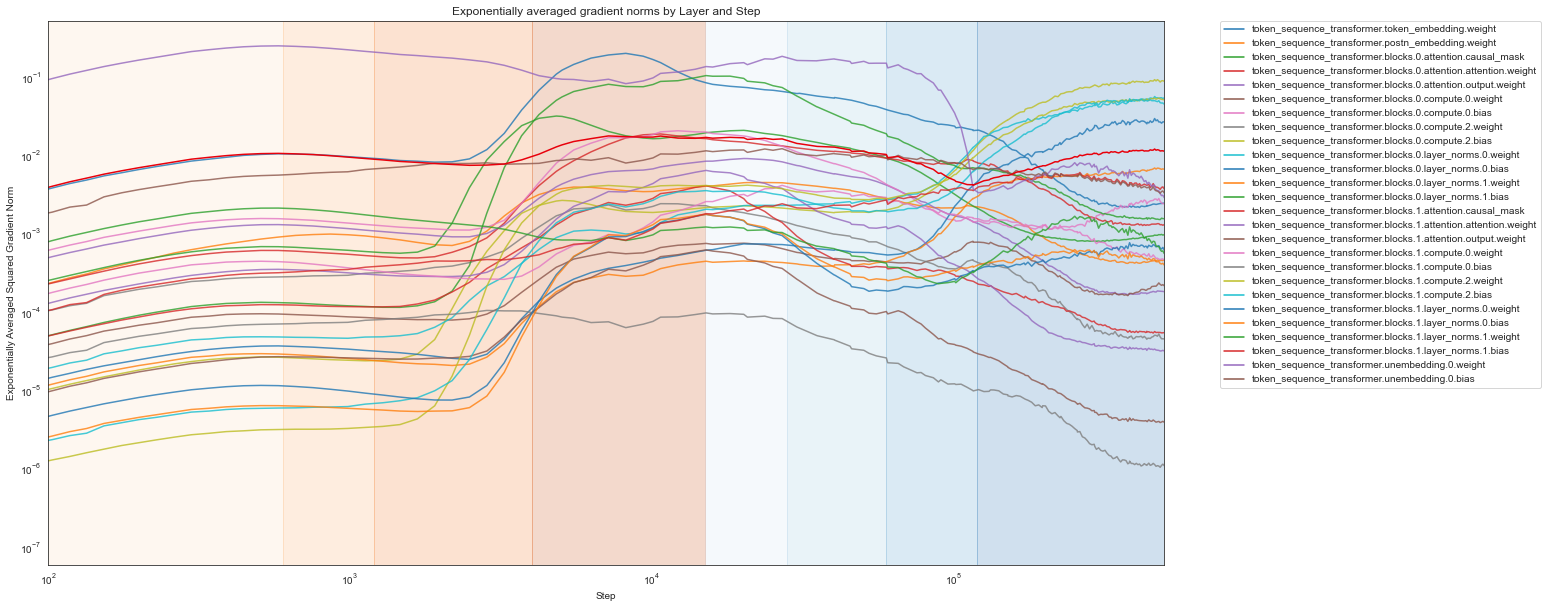

In [178]:
# Let's look at the optimizer state

optimizer_state_dicts0 = all_optimizer_state_dicts[0]

names = [n for n, _ in run0.model.named_parameters()]

optimizer_stats = []

for step, optimizer_state_dict in zip(steps, optimizer_state_dicts0):
    for layer, g in optimizer_state_dict["state"].items():
        optimizer_stats.append({
            "step": step,
            "layer": layer,
            "layer_name": list(model.state_dict().keys())[layer],
            "exp_avg_sq_norm": g["exp_avg_sq"].norm().item() + 0.0000001
        })

optimizer_stats = pd.DataFrame(optimizer_stats)
avg_optimizer_stats = optimizer_stats.groupby('step').mean()

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=optimizer_stats, x="step", y="exp_avg_sq_norm", hue="layer_name", palette="tab10", ax=ax, alpha=0.8)
sns.lineplot(data=avg_optimizer_stats, x="step", y="exp_avg_sq_norm", palette="viridis", ax=ax, color=BRED)
ax.set_ylabel("Exponentially Averaged Squared Gradient Norm")
ax.set_xlabel("Step")
ax.set_title("Exponentially averaged gradient norms by Layer and Step")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plot_transitions(ax, TRANSITIONS, limit=True)

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(100, 500_000)

In [179]:
# I want to see in what order the layers reach "zero"
# 1. Figure out the earliest step for each layer where exp_avg_sq_norm < 1e-5
# 2. Order by this earliest step
# 3. List the names

threshold = 3e-7

# Find the earliest step where exp_avg_sq_norm < threshold for each layer
earliest_zero_step = optimizer_stats[optimizer_stats['exp_avg_sq_norm'] < threshold] \
    .groupby('layer_name') \
    .agg(earliest_step=('step', 'min'))

# Now, sort the layers by the earliest step where their norm goes below the threshold
sorted_layers_by_earliest_zero_step = earliest_zero_step.sort_values(by='earliest_step')
sorted_layers_by_earliest_zero_step

,earliest_step
layer_name,
token_sequence_transformer.blocks.1.compute.2.bias,0
token_sequence_transformer.blocks.1.compute.2.weight,0
token_sequence_transformer.blocks.1.layer_norms.0.bias,0
token_sequence_transformer.blocks.1.layer_norms.0.weight,0


## Gradient essential dynamics

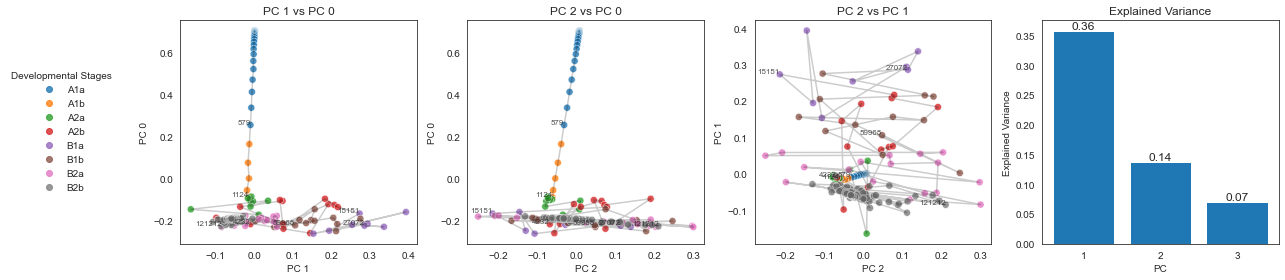

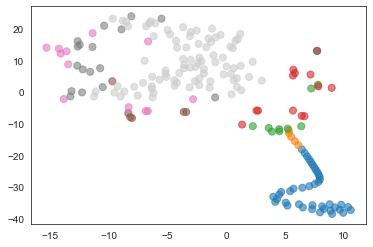

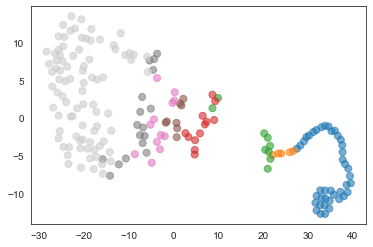

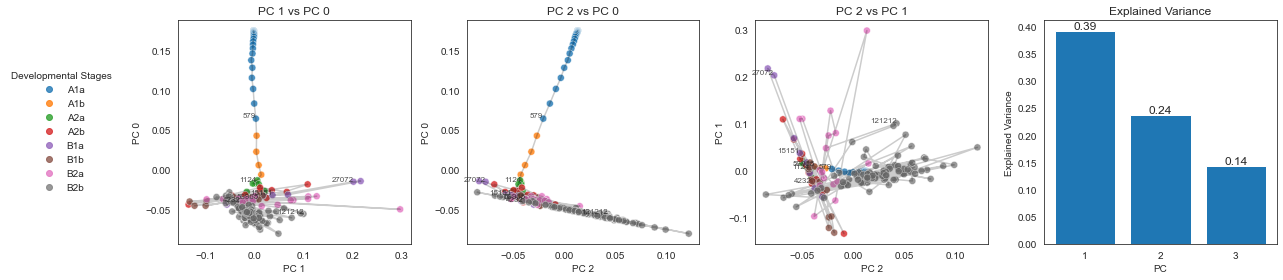

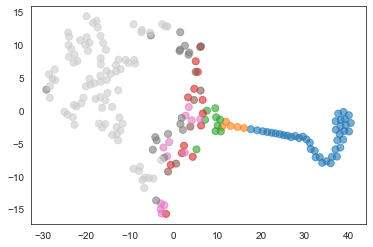

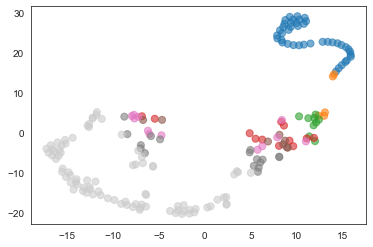

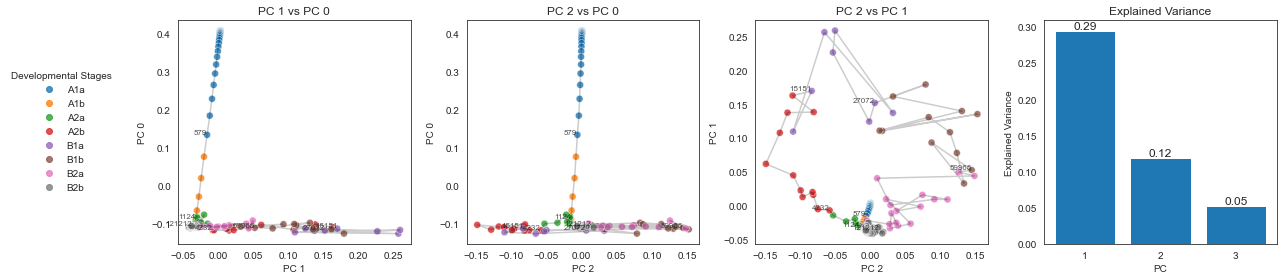

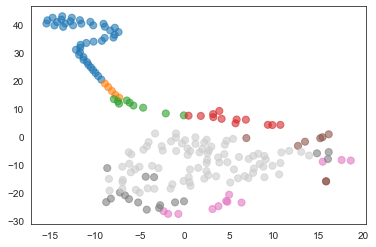

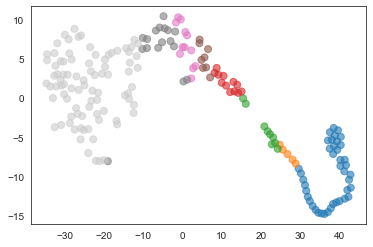

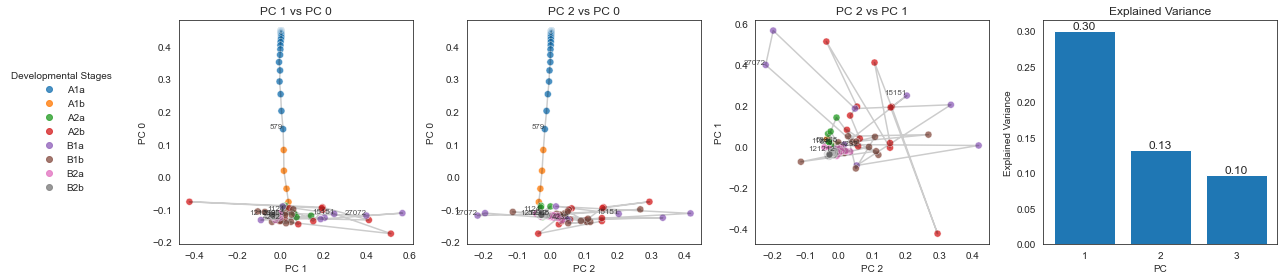

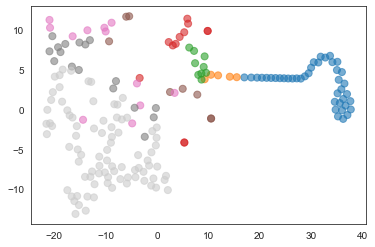

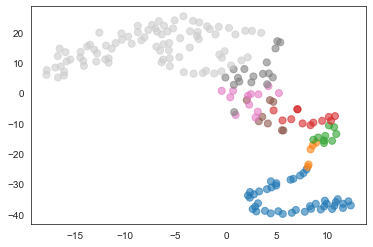

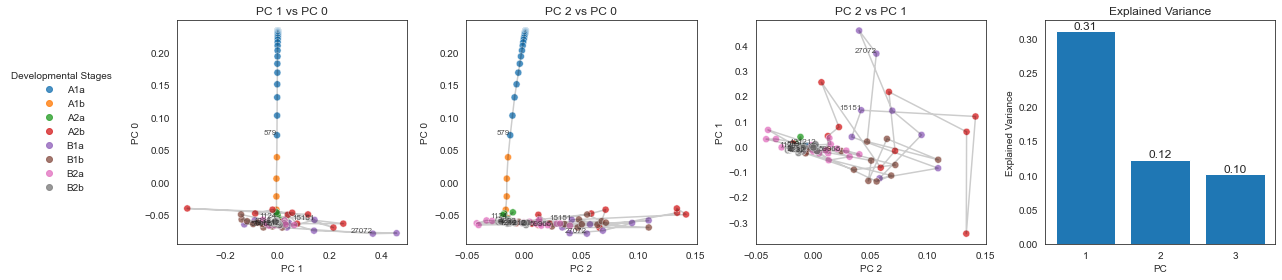

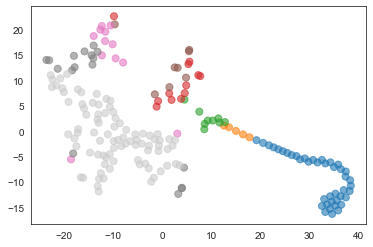

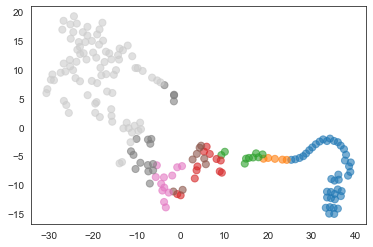

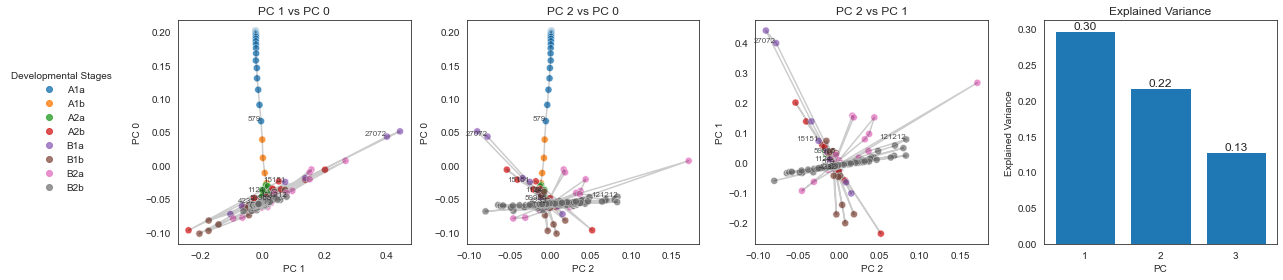

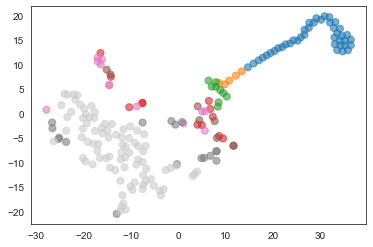

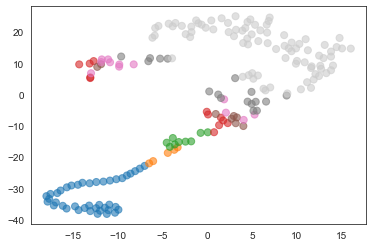

In [182]:
try:
    del gradients_over_time
    del gradients_reduced
    del gradients_reduced_normalized
except NameError:
    pass


PERPLEXITY = 15

for layer_name in [
    "token_sequence_transformer.token_embedding",
    "token_sequence_transformer.unembedding.0",
    "token_sequence_transformer.blocks.0.compute.0",
    "token_sequence_transformer.blocks.0.compute.2",
    "token_sequence_transformer.blocks.1.compute.0",
    "token_sequence_transformer.blocks.1.compute.2"
]:
    layer_path = layer_name.split(".")
    last_state_dict = models[-1].state_dict()
    num_params = 0
    
    for subset in ("weight", "bias"):
        subset_full_name = layer_name + "." + subset
        if subset_full_name in last_state_dict:
            num_params += models[-1].state_dict()[subset_full_name].numel()
            
    gradients_over_time = np.zeros((len(steps), num_params))

    def get_params(model, layer_path):
        m = model
        for part in layer_path:
            m = getattr(m, part)
        
        return m

    for i, model in enumerate(models):
        # model.train()
        model.to(DEVICE)
        model.zero_grad()

        yhats = model(xs, ys)

        loss = F.mse_loss(yhats, ys)
        loss.backward()

        layer = get_params(model, layer_path)

        n = 0
        for subset in ("weight", "bias"):
            if layer and hasattr(layer, subset):
                param = getattr(layer, subset)
                if param is None:
                    continue

                numel = param.numel()
                gradients_over_time[i, n:n+numel] = param.grad.flatten().cpu().numpy()
                n += numel

    pca = PCA(n_components=50)
    gradients_reduced = pca.fit_transform(gradients_over_time)

    norms = np.linalg.norm(gradients_over_time, axis=1, keepdims=True)
    norms[norms == 0] = 1

    gradients_reduced_normalized = pca.fit_transform(gradients_over_time / norms)

    plot_multiple_slices(
        steps, 
        gradients_reduced[:, :3], 
        pca, 
        TRANSITIONS,
        connect_dots=True, 
        save=None,
    )

    plt.show()

    tsne = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
    gradients_tsne = tsne.fit_transform(gradients_reduced)

    plt.scatter(gradients_tsne[:, 0], gradients_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
    plt.show()

    tsne_normalized = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
    gradients_tsne_normalized = tsne.fit_transform(gradients_reduced_normalized)

    plt.scatter(gradients_tsne_normalized[:, 0], gradients_tsne_normalized[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
    plt.show()

## Gradient clustering

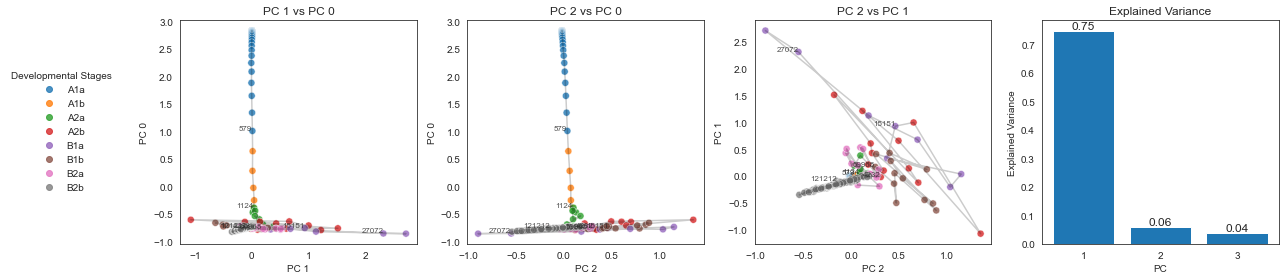

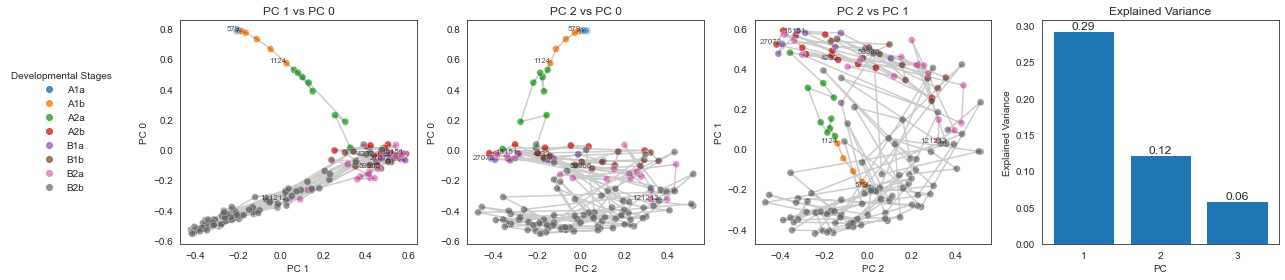

Full gradients
Unnormalized


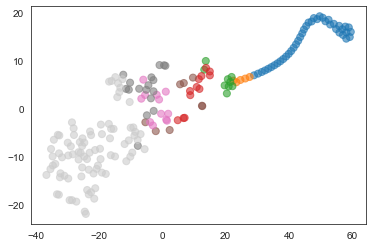

Normalized


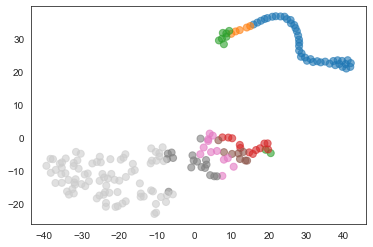

In [183]:
from torch.nn import functional as F
from sklearn.manifold import TSNE

try:
    del gradients_over_time
    del gradients_reduced
    del gradients_reduced_normalized
except NameError:
    pass

PERPLEXITY = 10

def get_all_params_as_array(model):
    return np.concatenate([p.cpu().numpy().flatten() for p in model.parameters()])


def get_all_gradients_as_array(model):
    return np.concatenate([p.grad.cpu().numpy().flatten() for p in model.parameters() if p.grad is not None])

gradients_over_time = []
gradients_normalized_over_time = []

for i, model in enumerate(models):
    # model.train()
    model.to(DEVICE)
    model.zero_grad()

    yhats = model(xs, ys)

    loss = F.mse_loss(yhats, ys)
    loss.backward()

    layer = get_params(model, layer_path)

    gradients = get_all_gradients_as_array(model)
    gradients_over_time.append(gradients)
    gradients_normalized_over_time.append(gradients / np.linalg.norm(gradients))

gradients_over_time = np.array(gradients_over_time)
gradients_normalized_over_time = np.array(gradients_normalized_over_time)

pca_1 = PCA(n_components=50)
gradients_reduced = pca_1.fit_transform(gradients_over_time)

pca_2 = PCA(n_components=50)
gradients_reduced_normalized = pca_2.fit_transform(gradients_normalized_over_time)

plot_multiple_slices(
    steps, 
    gradients_reduced[:, :3], 
    pca_1, 
    TRANSITIONS,
    connect_dots=True, 
    save=None,
)

plot_multiple_slices(
    steps, 
    gradients_reduced_normalized[:, :3], 
    pca_2, 
    TRANSITIONS,
    connect_dots=True, 
    save=None,
)

plt.show()


print("Full gradients")
print("Unnormalized")

tsne = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
gradients_tsne = tsne.fit_transform(gradients_reduced)

plt.scatter(gradients_tsne[:, 0], gradients_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

print("Normalized")

tsne_normalized = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
gradients_tsne_normalized = tsne.fit_transform(gradients_reduced_normalized)

plt.scatter(gradients_tsne_normalized[:, 0], gradients_tsne_normalized[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

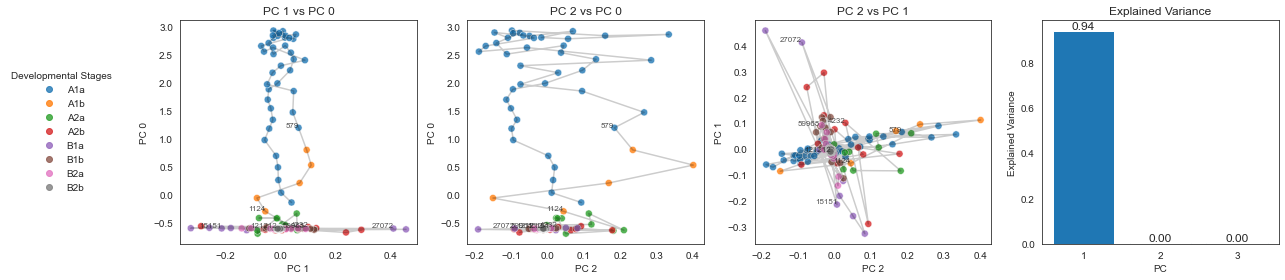

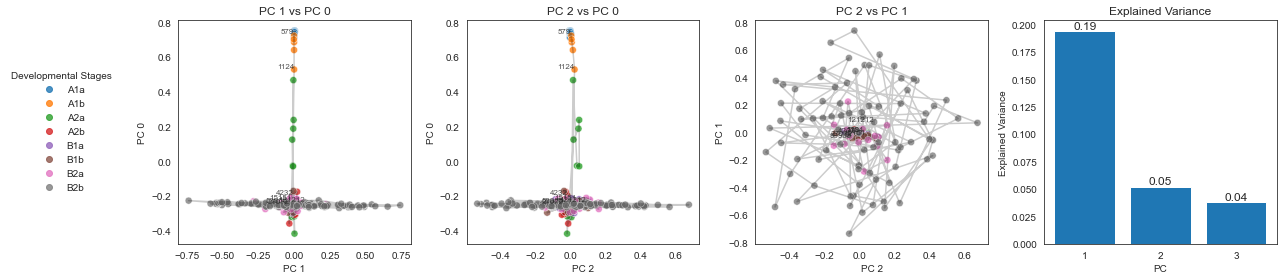

Exponentially averaged gradients
Unnormalized


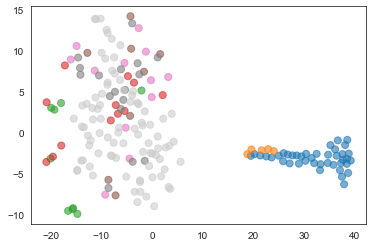

Normalized


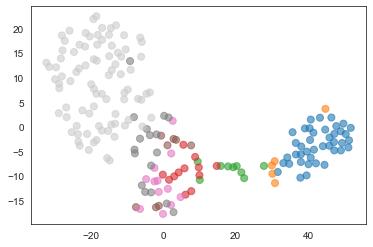

In [184]:
from torch.nn import functional as F
from sklearn.manifold import TSNE

try:
    del exp_avg_grads_over_time
    del exp_avg_grads_reduced
    del exp_avg_grads_reduced_normalized
except NameError:
    pass

PERPLEXITY = 15

exp_avg_grads_over_time = []
exp_avg_grads_normalized_over_time = []

def get_exp_avg_sq_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg_sq"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])

def get_exp_avg_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])


for i, opt_state in enumerate(optimizer_state_dicts):
    # model.train()
    exp_avg_grads = get_exp_avg_grads(opt_state)
    exp_avg_grads_over_time.append(exp_avg_grads)
    exp_avg_grads_normalized_over_time.append(exp_avg_grads / np.linalg.norm(exp_avg_grads))

exp_avg_grads_over_time = np.array(exp_avg_grads_over_time)
exp_avg_grads_normalized_over_time = np.array(exp_avg_grads_normalized_over_time)


pca_1 = PCA(n_components=50)
exp_avg_grads_reduced = pca_1.fit_transform(exp_avg_grads_over_time)

pca_2 = PCA(n_components=50)
exp_avg_grads_reduced_normalized = pca_2.fit_transform(exp_avg_grads_normalized_over_time)

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced[:, :3], 
    pca_1, 
    TRANSITIONS,
    connect_dots=True, 
    save=None,
)

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced_normalized[:, :3], 
    pca_2, 
    TRANSITIONS,
    connect_dots=True, 
    save=None,
)

plt.show()

print("Exponentially averaged gradients")
print("Unnormalized")

tsne = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
exp_avg_grads_tsne = tsne.fit_transform(exp_avg_grads_reduced)

plt.scatter(exp_avg_grads_tsne[:, 0], exp_avg_grads_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

print("Normalized")

tsne_normalized = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
exp_avg_grads_tsne_normalized = tsne.fit_transform(exp_avg_grads_reduced_normalized)

plt.scatter(exp_avg_grads_tsne_normalized[:, 0], exp_avg_grads_tsne_normalized[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

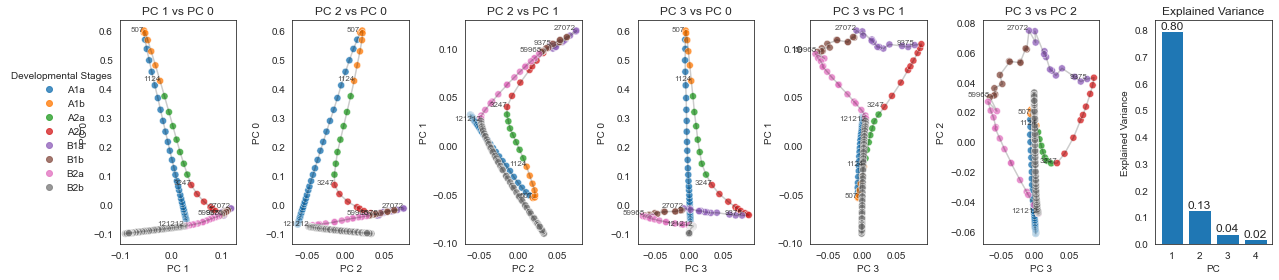

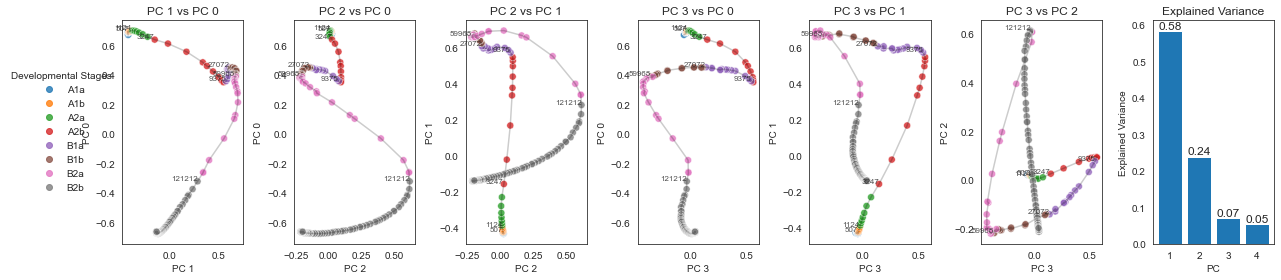

Exponentially averaged square gradients
Unnormalized


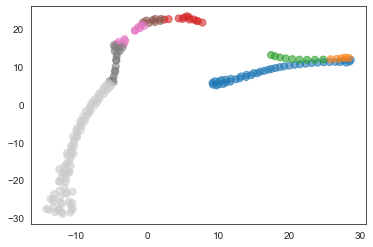

Normalized


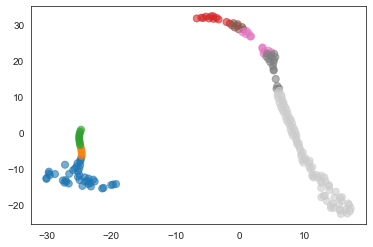

In [203]:
from torch.nn import functional as F
from sklearn.manifold import TSNE

try:
    del exp_avg_grads_over_time
    del exp_avg_grads_reduced
    del exp_avg_grads_reduced_normalized
except NameError:
    pass

PERPLEXITY = 15

exp_avg_grads_over_time = []
exp_avg_grads_normalized_over_time = []

def get_exp_avg_sq_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg_sq"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])

def get_exp_avg_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])


for i, opt_state in enumerate(optimizer_state_dicts):
    # model.train()
    exp_avg_grads = get_exp_avg_sq_grads(opt_state)
    exp_avg_grads_over_time.append(exp_avg_grads)
    exp_avg_grads_normalized_over_time.append(exp_avg_grads / np.linalg.norm(exp_avg_grads))

exp_avg_grads_over_time = np.array(exp_avg_grads_over_time)
exp_avg_grads_normalized_over_time = np.array(exp_avg_grads_normalized_over_time)

pca_1 = PCA(n_components=50)
exp_avg_grads_reduced = pca_1.fit_transform(exp_avg_grads_over_time)

pca_2 = PCA(n_components=50)
exp_avg_grads_reduced_normalized = pca_2.fit_transform(exp_avg_grads_normalized_over_time)

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced[:, :4], 
    pca_1, 
    TRANSITIONS,
    connect_dots=True, 
    save=None,
    # cmap=transitions_cmap
)

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced_normalized[:, :4], 
    pca_2, 
    TRANSITIONS,
    connect_dots=True, 
    save=None,
    # cmap=transitions_cmap,
)

plt.show()

print("Exponentially averaged square gradients")
print("Unnormalized")

tsne = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
exp_avg_grads_tsne = tsne.fit_transform(exp_avg_grads_reduced)

plt.scatter(exp_avg_grads_tsne[:, 0], exp_avg_grads_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

print("Normalized")
tsne_normalized = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
exp_avg_grads_tsne_normalized = tsne.fit_transform(exp_avg_grads_reduced_normalized)

plt.scatter(exp_avg_grads_tsne_normalized[:, 0], exp_avg_grads_tsne_normalized[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

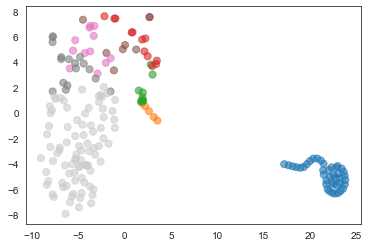

In [204]:

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
gradients_tsne = tsne.fit_transform(gradients_reduced)

plt.scatter(gradients_tsne[:, 0], gradients_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)

## Gradient vectors

Let's look at the delta in gradients at the kinks. 

In [ ]:
names = [n for n, _ in run.model.named_parameters()]

exp_avg_sq_grad_deltas = []

kink_steps = highlight_steps

for step in kink_steps:
    i = steps.index(step)

    opt_state_dict_curr = optimizer_state_dicts[i]

    for (layer, g_curr) in opt_state_dict_curr["state"].items():
        exp_avg_sq_grad_deltas.append({
            "step": step,
            "layer": layer,
            "layer_name": list(model.state_dict().keys())[layer],
            "exp_avg_sq_grad_sq_norm": ((g_curr["exp_avg_sq"]) ** 2).sum().item()
        })


exp_avg_sq_grad_deltas = pd.DataFrame(exp_avg_sq_grad_deltas)
total_exp_avg_sq_grad_deltas = exp_avg_sq_grad_deltas.groupby('step').sum()
exp_avg_sq_grad_deltas['exp_avg_sq_norm'] = exp_avg_sq_grad_deltas['exp_avg_sq_grad_sq_norm'] ** 0.5

for step in kink_steps:
    exp_avg_sq_grad_deltas.loc[exp_avg_sq_grad_deltas['step'] == step, 'exp_avg_sq_norm'] /= total_exp_avg_sq_grad_deltas.loc[step, 'exp_avg_sq_grad_sq_norm'] ** 0.5

avg_exp_avg_sq_grad_deltas = exp_avg_sq_grad_deltas.groupby('step').mean()

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=exp_avg_sq_grad_deltas, x="step", y="exp_avg_sq_norm", hue="layer_name", palette="tab10", ax=ax, alpha=0.5, legend=True)
sns.lineplot(data=avg_exp_avg_sq_grad_deltas, x="step", y="exp_avg_sq_norm", ax=ax, color=BRED)
ax.set_ylabel("Gradient Norm")
ax.set_xlabel("Step")
ax.set_title("Exponentially averaged gradient norms by Layer and Step")
# ax.legend().remove()

plot_transitions(ax, TRANSITIONS, limit=True)

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(100, 500_000)   

for step in highlight_steps:
    print("=" * 20 + f" Step {step} " + "=" * 20)
    print(exp_avg_sq_grad_deltas.loc[exp_avg_sq_grad_deltas['step'] == step, ['layer_name', 'exp_avg_sq_norm']].sort_values(by='exp_avg_sq_norm', ascending=False).head(10))

## Gradient clustering

## Per-token LLCs

## Per-token Essential Dynamics

# Structural indicators

## Contributions from different layers

In [ ]:
contributions = []
prev_state_dict = models[0].state_dict()

for step, model in zip(steps[1:], models[1:]):
    _contributions = []

    for layer, param in model.state_dict().items():
        w_sq_sum = (param ** 2).sum().item()
        w_delta_sq_sum = ((param - prev_state_dict[layer]) ** 2).sum().item()
        w_delta_sq_sum_normalized = w_delta_sq_sum / w_sq_sum

        if w_sq_sum == float("inf"):
            continue

        _contributions.append({
            "step": step,
            "layer": layer, 
            "w_sq_sum": w_sq_sum,
            "w_delta_sq_sum": w_delta_sq_sum,
            "w_delta_sq_sum_normalized": w_delta_sq_sum_normalized,
            "numel": param.numel(),
        })

    total_w_delta_sq_sum = sum([c["w_delta_sq_sum"] for c in _contributions])

    for c in _contributions:
        c["w_delta_sq_sum_frac"] = (c["w_delta_sq_sum"] / total_w_delta_sq_sum) ** 0.5

    contributions.extend(_contributions)
    prev_state_dict = model.state_dict()

contributions = pd.DataFrame(contributions)
contributions

In [ ]:
layers = contributions.layer.unique()
embed_layers = [layers[0], layers[1]]
block0_layers = [layers[i] for i in range(2, 2 + 9)]
block1_layers = [layers[i] for i in range(11, 11 + 9)]
unembed_layers = [layers[i] for i in range(11 + 9, len(layers))]

groupings = [embed_layers, block0_layers, block1_layers, unembed_layers]

In [ ]:
fig, axes = plt.subplots(len(groupings), figsize=(10, 20))
contributions["layer_name"] = [".".join(n.split(".")[1:]) for n in contributions.layer]

for ax, grouping in zip(axes, groupings):
    sns.lineplot(data=contributions.loc[contributions.layer.isin(grouping)], x="step", y="w_delta_sq_sum_frac", hue="layer_name", palette="deep", ax=ax, alpha=0.8)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False)

    # ax.legend().remove()
    ax.set_xscale('log')


# ax.set_yscale('log')
plot_transitions(axes, TRANSITIONS)


## Hessians

In [207]:
import pyhessian
from pyhessian import hessian # Hessian computation

xs, ys = xs.to('cpu'), ys.to('cpu')

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs):
        return self.model(inputs[0], inputs[1])
    
ref_model = ModelWrapper(deepcopy(models[-1]).to('cpu'))
hessian_comp = hessian(ref_model, F.mse_loss, data=((xs, ys), ys), cuda=False)

/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1156.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [208]:
def torch_eig_wrapper(*args, eigenvectors=True, **kwargs):
    # Call the new torch.linalg.eig function
    eigenvalues, eigenvecs = torch.linalg.eig(*args, **kwargs)
    
    # Format the output to mimic the old torch.eig
    # torch.eig used to return a tensor with [real, imaginary] parts for eigenvalues
    # torch.linalg.eig returns a tensor of complex numbers for eigenvalues
    eigenvalues_real = eigenvalues.real
    eigenvalues_imag = eigenvalues.imag

    eigenvalues_combined = torch.stack((eigenvalues_real, eigenvalues_imag), dim=-1)
    return eigenvalues_combined, eigenvecs

# Monkey patch the torch.eig function in the pyhessian module
torch.eig = torch_eig_wrapper 

density_eigen, density_weight = hessian_comp.density()

<ipython-input-209-bef27b2913ee>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


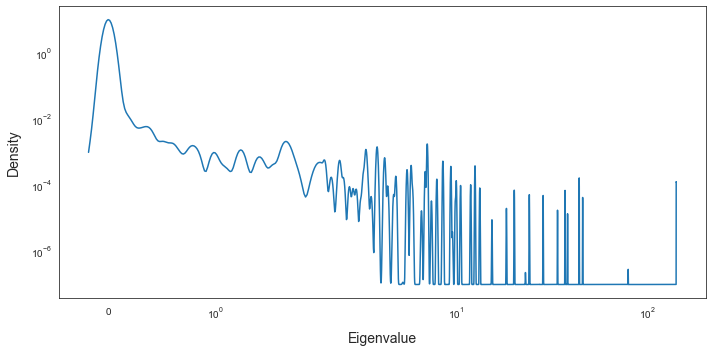

In [209]:
# From PyHessian

def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-5,
                     overhead=0.01):

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + overhead
    lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density, grids


def gaussian(x, x0, sigma_squared):
    return np.exp(-(x0 - x)**2 /
                  (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

def get_esd_plot(eigenvalues, weights, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    density, grids = density_generate(eigenvalues, weights)
    ax.semilogy(grids, density + 1.0e-7)
    ax.set_ylabel('Density', fontsize=14, labelpad=10)
    ax.set_xlabel('Eigenvalue', fontsize=14, labelpad=10)
    # plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    ax.set_xscale('symlog')
    plt.tight_layout()

get_esd_plot(density_eigen, density_weight)

In [210]:
top_evals = []
hessian_traces = []

xs = xs.to('cpu')
ys = ys.to('cpu')

for model in tqdm.tqdm(models):
    model = model.to('cpu')
    ref_model = ModelWrapper(model)
    hessian_comp = hessian(ref_model, F.mse_loss, data=((xs, ys), ys), cuda=False)

    _top_evals, _ = hessian_comp.eigenvalues(top_n=3)
    trace = hessian_comp.trace()

    top_evals.append(_top_evals)
    hessian_traces.append(trace)

    model.to('mps')

xs = xs.to('mps')
ys = ys.to('mps')

100%|██████████| 190/190 [34:10<00:00, 10.79s/it] 


/Users/Jesse/Projects/icl/icl/figures/colors.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)


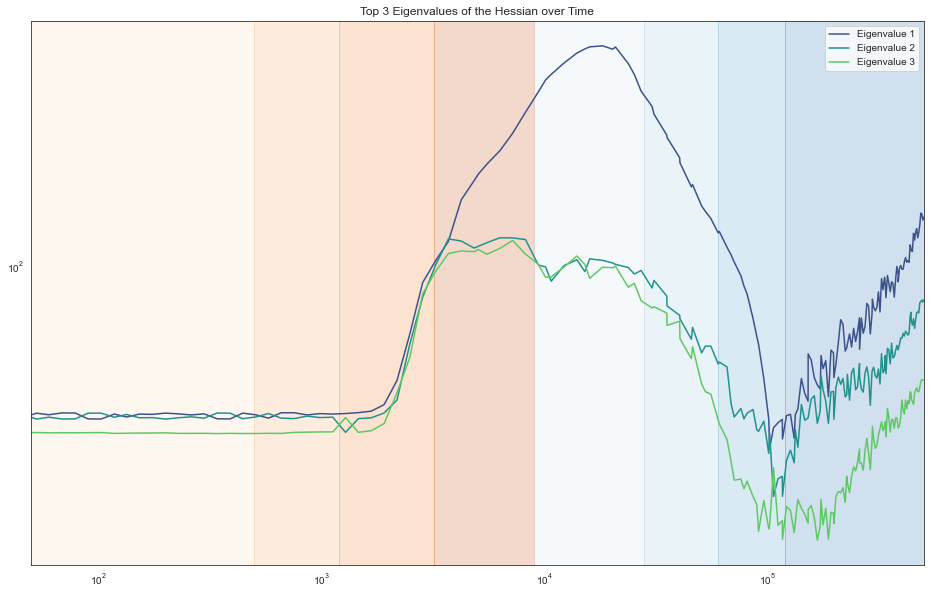

In [227]:
# top_evals = np.array(top_evals)
# hessian_traces = np.array(hessian_traces)

fig, ax = plt.subplots(figsize=(16, 10))

cmap3 = sns.color_palette("viridis", 3)

sns.lineplot(x=steps, y=top_evals[:, 0], color=cmap3[0], label="Eigenvalue 1", ax=ax)
sns.lineplot(x=steps, y=top_evals[:, 1], color=cmap3[1], label="Eigenvalue 2", ax=ax)
sns.lineplot(x=steps, y=top_evals[:, 2], color=cmap3[2], label="Eigenvalue 3", ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
plot_transitions(ax, TRANSITIONS, limit=True)
ax.set_xlim(50, 500_000)

plt.title("Top 3 Eigenvalues of the Hessian over Time")
plt.show()

/Users/Jesse/Projects/icl/icl/figures/colors.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)


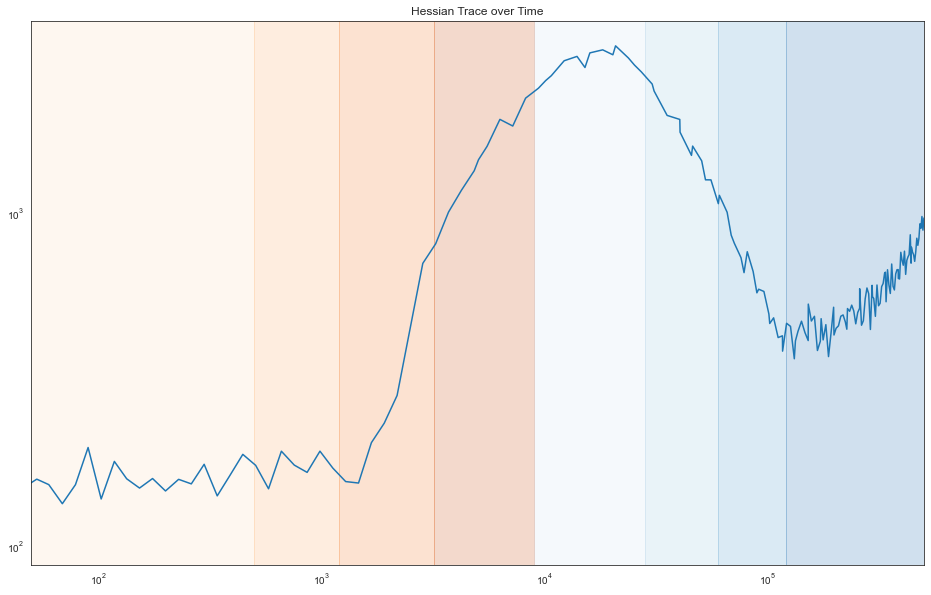

In [235]:
hessian_traces_np = np.array([np.mean(t) for t in hessian_traces])

fig, ax = plt.subplots(figsize=(16, 10))

cmap3 = sns.color_palette("viridis", 3)

sns.lineplot(x=steps, y=hessian_traces_np, ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
plot_transitions(ax, TRANSITIONS, limit=True)
ax.set_xlim(50, 500_000)

plt.title("Hessian Trace over Time")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))

cmap3 = sns.color_palette("viridis", 3)

sns.lineplot(x=steps, y=top_evals[:, 0], color=cmap3[0], label="Eigenvalue 1", ax=ax)
sns.lineplot(x=steps, y=top_evals[:, 1], color=cmap3[1], label="Eigenvalue 2", ax=ax)
sns.lineplot(x=steps, y=top_evals[:, 2], color=cmap3[2], label="Eigenvalue 3", ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
plot_transitions(ax, TRANSITIONS, limit=True)
ax.set_xlim(50, 500_000)

plt.title("Top 3 Eigenvalues of the Hessian over Time")
plt.show()

In [211]:
densities_over_time = []

xs = xs.to('cpu')
ys = ys.to('cpu')

INIT_STAGE = 3
kink_steps = highlight_steps[INIT_STAGE:]
stage_labels = [t[2] + f" Start ({s})" for s, t in zip(kink_steps, TRANSITIONS[INIT_STAGE:])] + [TRANSITIONS[-1][2] + f" End ({kink_steps[-1]})"]
models_subset = [steps_to_models[step] for step in kink_steps]

for step, model, label in tqdm.tqdm(zip(kink_steps, models_subset, stage_labels), total=len(kink_steps)):
    print(step)
    model = model.to('cpu')
    ref_model = ModelWrapper(model)
    hessian_comp = hessian(ref_model, F.mse_loss, data=((xs, ys), ys), cuda=False)
    density_eigen, density_weight = hessian_comp.density()
    densities_over_time.append((density_eigen, density_weight))

    get_esd_plot(density_eigen, density_weight)
    plt.title(label)
    plt.show()

    model.to('mps')

xs = xs.to('mps')
ys = ys.to('mps')

NameError: name 'steps_to_models' is not defined

In [ ]:
fig, axes = plt.subplots(len(densities_over_time), figsize=(10, 5 * len(densities_over_time)))

min_eigen = min([min(density_eigen[0]) for density_eigen, _ in densities_over_time])
max_eigen = max([max(density_eigen[0]) for density_eigen, _ in densities_over_time])

print(min_eigen, max_eigen)

for step, label, ax, (density_eigen, density_weight) in tqdm.tqdm(zip(kink_steps, stage_labels, axes, densities_over_time), total=len(kink_steps)):
    get_esd_plot(density_eigen, density_weight, ax=ax)
    # ax.set_yscale('linear')
    ax.set_xlim(min_eigen, max_eigen)
    ax.set_title(label)

fig.set_facecolor('white')

## Restricted Hessians

Let's look at the Hessians within a few specific layers of the model. This will make it possible to study the full Hessian. 

In [ ]:
import torch

def compute_hessian_layer(model, loss, layer=None):
    """
    Compute the Hessian matrix for a specific layer of a neural network model.

    :param model: The neural network model (PyTorch).
    :param loss_fn: The loss function.
    :param input_tensor: Input tensor for the model.
    :param target_tensor: Target tensor for computing the loss.
    :param layer_name: The name of the layer for which to compute the Hessian.
    :return: The Hessian matrix for the specified layer.
    """
    # Ensure model is in eval mode for consistent forward pass
    model.eval()

    if layer is None:
        layer = lambda m: [p for n, p in m.named_parameters() if not torch.any(torch.isnan(p))]

    if isinstance(layer, str):
        layer = lambda m: [p for n, p in m.named_parameters() if not torch.any(torch.isnan(p)) and layer in n]

    # Get the parameters of the specified layer
    layer_params = layer(model)

    if not layer_params:
        raise ValueError(f"No parameters found for layer: {layer_name}")

    # Flatten the parameters and compute the first gradient
    grads = torch.autograd.grad(loss, layer_params, create_graph=True)
    grads_flatten = torch.cat([g.view(-1) for g in grads])

    hessian = []

    # Compute second derivatives (Hessian)
    for grad in tqdm.tqdm(grads_flatten):
        grad_grads = torch.autograd.grad(grad, layer_params, retain_graph=True)
        grad_grads_flatten = torch.cat([g.view(-1) for g in grad_grads]).detach()
        hessian.append(grad_grads_flatten)

    # Convert the list of gradients to a tensor (Hessian matrix)
    hessian = torch.stack(hessian)

    return hessian

# Example usage (assuming a model, loss function, input_tensor, target_tensor, and layer_name are defined)
# hessian_matrix = compute_hessian_layer(model, loss_fn, input_tensor, target_tensor, layer_name)
# print(hessian_matrix)

# Note: This function doesn't execute the computation as it requires a specific model, loss function, input and target tensors, and layer name.


In [ ]:
hessians_over_time = []
hessian_evals_over_time = []
hessian_evecs_over_time = []

xs, ys = xs.to('cpu'), ys.to('cpu')

def get_layer(model):
    return list(model.token_sequence_transformer.blocks[BLOCK_IDX].attention.parameters())

for step, model, label in tqdm.tqdm(zip(kink_steps, models_subset, stage_labels), total=len(kink_steps)):
    model.to('cpu') 
    print(step)

    model.zero_grad()
    model.eval()

    y_hats = model(xs, ys)
    loss = F.mse_loss(y_hats, ys)
    hessian = compute_hessian_layer(model, loss, get_layer)

    evals, evecs = torch.linalg.eig(hessian)

    hessians_over_time.append(hessian)
    hessian_evals_over_time.append(evals)
    hessian_evecs_over_time.append(evecs)

    print(evals)
    abs_evals = torch.abs(evals)
    
    # Plot eigenvalue density
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(abs_evals, bins=100, log=True)
    plt.show()
    
    model.to('mps')

xs = xs.to('mps')
ys = ys.to('mps')

## Parametric Essential Dynamics

In [ ]:
# Let's try this for restricted subsets of weights as well

from typing import Callable


def extract_weights_over_checkpoints(models: Iterable[nn.Module], extract_weights: Callable = lambda m: [p.flatten() for p in m.parameters()], normalize=False):
    for model in models:
        weights = torch.cat(extract_weights(model)).detach().cpu().numpy()

        if normalize:
            weights /= np.linalg.norm(weights)

        yield weights



def get_pca_weights_trace(models: Iterable[nn.Module], extract_weights: Callable = lambda m: [p.flatten() for p in m.parameters()], num_components=3, normalize=False) -> Dict[str, Tuple[PCA, np.ndarray]]:
    weights = np.array([w for w in extract_weights_over_checkpoints(models, extract_weights, normalize=normalize)])

    pca = PCA(n_components=num_components)
    weights_reduced = pca.fit_transform(weights)

    return weights_reduced, pca

all_weights, weights_pca = get_pca_weights_trace(models, num_components=3, normalize=False)

plot_multiple_slices(
    steps, 
    all_weights, 
    weights_pca, 
transitions,

    transitions_of_steps,
    connect_dots=True, 
    save=None,
)
plt.show()


In [ ]:
extract_embedding_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.token_embedding.parameters()]
extract_unembedding_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.unembedding[1].parameters()]
extract_embedding_unembedding_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.token_embedding.parameters()] + [p.flatten() for p in m.token_sequence_transformer.unembedding[1].parameters()]
extract_block_0_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[0].parameters()]
extract_block_1_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[1].parameters()]
extract_lns = lambda m: [m.state_dict()[f"{ln}.{part}"] for ln in layer_norms for part in ["weight", "bias"]]
extract_mlp_0 = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[0].compute[0].parameters()] + [p.flatten() for p in m.token_sequence_transformer.blocks[0].compute[2].parameters()]
extract_mlp_1 = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[1].compute[0].parameters()] + [p.flatten() for p in m.token_sequence_transformer.blocks[1].compute[2].parameters()]
extract_attn_0 = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[0].attention.attention.parameters()]
extract_attn_1 = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[1].attention.attention.parameters()]

extract_weights_fns = {
    "Embedding & Unembedding": extract_embedding_unembedding_weights, 
    "Unembedding": extract_unembedding_weights, 
    "Embedding": extract_embedding_weights, 
    "Block 0": extract_block_0_weights, 
    "Block 1": extract_block_1_weights, 
    "Layer norms": extract_lns,
    "MLP 0": extract_mlp_0,
    "MLP 1": extract_mlp_1,
    "Attention 0": extract_attn_0,
    "Attention 1": extract_attn_1,
}

for label, extract_weights in extract_weights_fns.items():
    print(label)

    for normalize in [False, True]:
        print(f"Normalize: {normalize}")
        subset_weights, weights_pca = get_pca_weights_trace(models, num_components=3, extract_weights=extract_weights, normalize=normalize)

        plot_multiple_slices(
            steps, 
            subset_weights, 
            weights_pca, 
            highlight_steps,
            transitions_of_steps,
            connect_dots=True, 
            save=None,
        )
        plt.show()



## Embedding

In [ ]:
steps = run.checkpointer.file_ids
embedding_matrices = []  # Shape: (64, 5): 64 vectors x (1 y dim + 4 x dims)

for model in models:
    embedding_matrices.append(model.state_dict()['token_sequence_transformer.token_embedding.weight'])


embedding_vec_x_norms = [vec.norm(dim=1) for vec in embedding_matrices]  # (64,)

In [ ]:
# PCA explained Variance over time
pcas = []

for model in models:
    embed = model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy()
    pca = PCA(n_components=embed.shape[1])
    proj = pca.fit_transform(embed)[:,:3]
    pcas.append((proj, pca))

explained_variances = [{"value": value, "index": idx, "step": step} for step, (_, pca) in zip(steps, pcas) for idx, value in enumerate(pca.explained_variance_ratio_)]
explained_variances = pd.DataFrame(explained_variances)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=explained_variances, x="step", y="value", hue="index", palette="viridis", ax=ax)
ax.legend(title="Component", loc='upper left')
ax.set_xscale('log')
ax.set_title("Explained Variance of Embedding Vector PCA over Time")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Step, $t$")

fig.set_facecolor('white')
plot_transitions(ax, TRANSITIONS, limit=True)

In [ ]:
# Using the final PCA

def compute_explained_variance(pca, embed):
    proj = pca.transform(embed)

    # Step 4 and 5: Compute variance of projected data and total variance
    variance_projected = np.var(proj, axis=0)
    total_variance = np.sum(variance_projected)

    # Step 6: Calculate explained variance ratio
    explained_variance_ratio = variance_projected / total_variance

    return explained_variance_ratio

explained_variances_rel_last_pca = [{"value": value, "index": idx, "step": step} for step, embed in zip(steps, embedding_matrices) for idx, value in enumerate(compute_explained_variance(pcas[-1][-1], embed.detach().cpu().numpy()))]
explained_variances_rel_last_pca = pd.DataFrame(explained_variances_rel_last_pca)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=explained_variances_rel_last_pca, x="step", y="value", hue="index", palette="viridis", ax=ax)
ax.legend(title="Component", loc='upper left')

ax.set_xscale('log')
ax.set_title("Explained Variance of Embedding Vector PCA over Time")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Step, $t$")

fig.set_facecolor('white')

plot_transitions(ax, TRANSITIONS, limit=True)

In [ ]:
# Let's project embedding vectors onto these pca components and track their evolution
last_pca = pcas[-1][-1]
transformed = [last_pca.transform(embed.detach().cpu().numpy()) for embed in embedding_matrices]
transition_middles = [get_nearest_step((t[0] + t[1]) * 0.5) for t in TRANSITIONS]

fig, axes = plt.subplots(1, len(transition_middles), figsize=(20, 5))

min_x, max_x = 0, 0
min_y, max_y = 0, 0

for ax, middle in zip(axes, transition_middles):
    middle_idx = steps.index(middle)
    middle_embeddings = transformed[middle_idx]
    sns.scatterplot(data=pd.DataFrame(middle_embeddings), x=0, y=1, ax=ax)
    ax.set_title(f"Step {middle}")

    min_x = min(min_x, middle_embeddings[:, 0].min())
    max_x = max(max_x, middle_embeddings[:, 0].max())
    min_y = min(min_y, middle_embeddings[:, 1].min())
    max_y = max(max_y, middle_embeddings[:, 1].max())

for ax in axes:
    ax.set_xlim(min_x * 1.25, max_x * 1.25)
    ax.set_ylim(min_y * 1.25, max_y * 1.25)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming 'pcas', 'embedding_matrices', 'TRANSITIONS', and 'steps' are defined as in your context.

last_pca = pcas[-1][-1]
transformed = [last_pca.transform(embed.detach().cpu().numpy()) for embed in embedding_matrices]
transition_middles = [get_nearest_step((t[0] + t[1]) * 0.5) for t in TRANSITIONS]

min_x, max_x = min([t[:, 0].min() for t in transformed]), max([t[:, 0].max() for t in transformed])
min_y, max_y = min([t[:, 1].min() for t in transformed]), max([t[:, 1].max() for t in transformed])

# Set up the figure.
fig, ax = plt.subplots(figsize=(8, 6))
plt.xlim(min_x * 1.25, max_x * 1.25)
plt.ylim(min_y * 1.25, max_y * 1.25)
scat = ax.scatter([], [])

# Update function for the animation.
def update(frame):
    middle_embeddings = transformed[frame]
    ax.clear()
    ax.set_xlim(min_x * 1.25, max_x * 1.25)
    ax.set_ylim(min_y * 1.25, max_y * 1.25)
    ax.set_title(f"Step {steps[frame]}")
    sns.scatterplot(data=pd.DataFrame(middle_embeddings), x=0, y=1, ax=ax)

# Create the animation.
ani = FuncAnimation(fig, update, frames=range(len(steps)), repeat=False)

# To save the animation, you can use the following line:
ani.save(FIGURES / 'M1-embed.mp4', writer='ffmpeg', fps=1)

plt.show()


## Unembedding

In [ ]:
unembeddings = []

for step, model in zip(steps, models):
    for subset in ["weight", "bias"]:
        layer = f"ln.{subset}"
        for i, param in enumerate(getattr(model.token_sequence_transformer.unembedding[0], subset)):
            unembeddings.append({"p": param.item(), "step": step, "layer": layer, "i": i})

        layer = f"linear.{subset}"
        layer_param = getattr(model.token_sequence_transformer.unembedding[1], subset)
        if subset == "weight":
            layer_param = layer_param[0, :]
            for i, param in enumerate(layer_param):
                unembeddings.append({"p": param.item(), "step": step, "layer": layer, "i": i})
        else:
            layer_param = layer_param[0]
            unembeddings.append({"p": layer_param.item(), "step": step, "layer": layer, "i": 0})


unembeddings = pd.DataFrame(unembeddings)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for i, layer in enumerate(["ln", "linear"]):
    for j, layer_subset in enumerate(["weight", "bias"]):
        sns.lineplot(data=unembeddings.loc[unembeddings.layer == f"{layer}.{layer_subset}"], x="step", y="p", hue="i", palette="viridis", ax=axes[i, j], alpha=0.25)
        axes[i, j].legend().remove()
        axes[i, j].set_xscale('log')
        axes[i, j].set_title(f"{layer}.{layer_subset}")

        axes[i, j].set_xlim(200, 500000)


fig.suptitle("Unembedding Weights over Time", fontsize=20)

plot_transitions(axes, TRANSITIONS);


Given $z$, the activations in the residual stream right before the unembedding, a 64-dimensional vector (per token). 

The unembedding performs the following operation: 

$$
\pi_y \left[ W_U \cdot \left( \frac{z-\mathbb E[z]}{\sqrt{\mathbb V[z] + \epsilon}} * \gamma + \beta \right) + b_U \right].
$$

This can be rewritten as follows:

$$
\left((W_U)_{[0, :]} * \gamma \right) \cdot \left(\frac{z-\mathbb E[z]}{\sqrt{\mathbb V[z] + \epsilon}}\right) + \left((W_U)_{[0, :]} \cdot \beta\right) + (b_U)_{[0]}
$$

Let's look at these "reduced" weights instead:
$$
\tilde W_U = (W_U)_{[0, :]} * \gamma,
$$
and
$$
\tilde b_U = \left((W_U)_{[0, :]} \cdot \beta\right) + (b_U)_{[0]}.
$$

How do you get around the $\mathbb E[z]$? (For now, assume that $\mathbb V[z]=1-\epsilon$).
Answer: You make sure that $\mathbb E[z] = 0$. 

Let's look at two possible implementations:

**1: One-hot $z$**

Suppose $z$ contains mostly balanced white noise. The signal (which we'll read the final prediction from) is contained in a single dimension $j$. 
Then, from the perspective of the average, we can view $z$ as a 1-hot vector, 

$$
z_i = z_j \delta_{ij}.
$$

Then, the average is

$$
\mathbb E[z] = \frac{1}{d_E} \sum_{j=1}^{d_E} z_j = \frac{1}{M} z_i,
$$

where $d_E=64$ is the dimension of the embedding / residual stream, and 

$$
z - \mathbb E[z] =  z_j \left(1 - \frac{1}{d_E}\right) \delta_{ij}.
$$

By setting $\gamma_j = \frac{d_E}{d_E-1}$, and we're able to read out the prediction. 

**2: Balanced $z$**

Again, assume that most components of $z$ contain balanced white noise. This time, however, we assume the signal is contained in two dimensions, $j$ and $k$. Assume that the signal is encoded with opposite magnitudes:

$$
z_i = z_j (\delta_{ij} - \delta_{ik}).
$$

Then, the average is:

$$
\mathbb E[z] = z_j \left(1 - 1\right) / d_E = 0.
$$

**During B2, we see a transition from (2) to (1).**

And if you look back further, we see additional transitions of this kind, where we have two negatively encoded signals that collapse together. 

Okay but why?

**Now, let's reintroduce the $\mathbb V[z]$ term.**

The problem with this term is that the input $x$ does not have a fixed norm, so the variance depends on $\mathbb V[x]$. 
The key observation is that we can set several extra dimensions in the residual stream to values that are arbitraily large in value. 

That is, by increasing the variance of the white noise contributions, we can suppress the contribution of the variance of the input and set $\mathbb V[z]$ to an arbitrary fixed value $v$ that we can cancel out with $\gamma$. 

Because (2) has the signal redundantly encoded, the contribution from $\mathbb V[x]$ is larger. So we can reduce the loss by changing to (1). 
But this also increases the degeneacy! As soon as $z_k$ no longer contains a signal, it can freely mix with all the other white noise contributions. We move from a set of $O(d_E-2)$ symmetries to a set of $O(d_E-1)$ symmetries.

Unfortunately, this transition doesn't have a Bayesian antecedent. Or does it? Remember, the $\gamma_i$ in the layer norm are initialized at $1$. So it's still very much possible that we have an "A-B" transition in which both loss and learning coefficient decrease in exchange for a significant increase in the prior contribution. 

In [ ]:
reduced_unembeddings = []

for step, model in zip(steps, models):
    reduced_weight = model.token_sequence_transformer.unembedding[1].weight[0, :] * model.token_sequence_transformer.unembedding[0].weight
    reduced_bias = model.token_sequence_transformer.unembedding[1].weight[0, :] @ model.token_sequence_transformer.unembedding[0].bias + model.token_sequence_transformer.unembedding[1].bias[0]

    for i, param in enumerate(reduced_weight):
        reduced_unembeddings.append({"p": param.item(), "subset": "weight", "step": step,  "i": i})

    reduced_unembeddings.append({"p": reduced_bias.item(), "subset": "bias", "step": step,  "i": 0})

reduced_unembeddings = pd.DataFrame(reduced_unembeddings)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))


ax = axes[0]
sns.lineplot(data=reduced_unembeddings.loc[reduced_unembeddings.subset == "weight"], x="step", y="p", hue="i", palette="viridis", ax=ax, alpha=0.25)
ax.set_title(f"{layer}.{layer_subset}")

ax = axes[1]
sns.lineplot(data=reduced_unembeddings.loc[reduced_unembeddings.subset == "bias"], x="step", y="p", hue="i", palette="viridis", ax=ax)

for ax in axes:
    ax.legend().remove()
    ax.set_xscale('log')
    ax.set_title(f"Reduced {layer_subset}")
    ax.set_xlim(200, 500000)

plot_transitions(axes, TRANSITIONS);

## Zero ablations

In [ ]:
bias_stats = []

for step, model in zip(steps, models):
    state_dict = model.state_dict()

    bias_stats.append({
        "step": step,
        "postn_embedding_norm": state_dict["token_sequence_transformer.postn_embedding.weight"].norm().item(),
        "unembedding_ln_bias_norm": state_dict["token_sequence_transformer.unembedding.0.bias"].norm().item(),    
    })

bias_stats = pd.DataFrame(bias_stats)

In [ ]:
postn_embeddings = []
unembedding_biases = []

for step, model in zip(steps, models):
    state_dict = model.state_dict()

    _postn_embedding = state_dict["token_sequence_transformer.postn_embedding.weight"]

    for i, p in enumerate(_postn_embedding):
        postn_embeddings.append({
            "step": step,
            "postn_embedding_0": p[0].item(),
            "idx": i,
            "postn_embedding_x_std": p[::2].std().item(),
            "postn_embedding_x_mean": p[::2].mean().item(),
            "postn_embedding_y_std": p[1::2].std().item(),
            "postn_embedding_y_mean": p[1::2].mean().item(),
        })

    _unembedding_bias = state_dict["token_sequence_transformer.unembedding.0.bias"]
    for i, p in enumerate(_unembedding_bias):
        unembedding_biases.append({
            "step": step,
            "unembedding_bias": p.item(),
            "idx": i
        })

postn_embeddings = pd.DataFrame(postn_embeddings)
unembedding_biases = pd.DataFrame(unembedding_biases)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 2))

axes[0].matshow(models[-1].token_sequence_transformer.postn_embedding.weight[:, ::2].T.detach().cpu().numpy(), aspect="auto")
axes[1].matshow(models[-1].token_sequence_transformer.postn_embedding.weight[:, 1::2].T.detach().cpu().numpy(), aspect="auto")

plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

ax.matshow(models[-1].token_sequence_transformer.unembedding[0].bias.reshape((1, 64)).detach().cpu().numpy(), aspect="auto")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

ax = axes[0]
# sns.lineplot(data=bias_stats, x="step", y="postn_embedding_norm", ax=ax)
sns.lineplot(data=postn_embeddings, x="step", y="postn_embedding_0", hue="idx", palette="gray", ax=ax, alpha=0.5)

ax.set_xscale("log")

ax = axes[1]
# sns.lineplot(data=bias_stats, x="step", y="unembedding_ln_bias_norm", ax=ax)
sns.lineplot(data=unembedding_biases, x="step", y="unembedding_bias", hue="idx", palette="gray", ax=ax, alpha=0.5)
ax.set_xscale("log")

plot_transitions(axes, TRANSITIONS, limit=True)

In [ ]:
from matplotlib import patches
from icl.model import to_token_sequence, from_predicted_token_sequence

class EmbedUnembedOnlyV2(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.to_token_sequence = to_token_sequence
        self.token_embedding = model.token_sequence_transformer.token_embedding
        self.positional_embedding = model.token_sequence_transformer.postn_embedding
        self.unembedding = model.token_sequence_transformer.unembedding
        self.from_predicted_token_sequence = from_predicted_token_sequence

    def forward(self, xs, ys):
        tokens = self.to_token_sequence(xs, ys)

        T = tokens.shape[1]
        x = self.token_embedding(tokens) # + self.positional_embedding.weight.T[:T, :]
        # Set everything to zero except for dimensions 46 and 51
        # embedded[:, :, :46] = 0
        # embedded[:, :, 47:51] = 0
        # embedded[:, :, 52:] = 0

        x = self.unembedding[0](x)
        unembedded = self.unembedding[1](x)

        # raise ValueError("Done")
    
        return self.from_predicted_token_sequence(unembedded)


# embed_unembed_only_model = EmbedUnembedOnly(run.model)

def get_embed_unembed_with_bias(model, multiplier=1.):
    eu_model = EmbedUnembedOnlyV2(model).to('cpu')

    w = np.zeros(4)
    basis = torch.eye(4, device="cpu") * multiplier
    ys = torch.zeros(1, 1, 1, device="cpu") 

    for i in range(4):
        w[i] = eu_model(basis[i].unsqueeze(0).unsqueeze(0), ys)[0].item()

    return w


embed_unembed_with_bias = [
    get_embed_unembed_with_bias(model, 10)
    for model in models
]

print(embed_unembed_with_bias[0].shape, task_embed.shape)

cossims = [
    (v @ task_np) / (np.linalg.norm(v) * np.linalg.norm(task_np)) for v in embed_unembed_with_bias
]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(run.checkpointer.file_ids, cossims)
ax.set_xscale("log")
ax.set_xlabel("step")
ax.set_ylabel(r"Cosine similarity with $w_1$")
ax.set_title("Effective weight using only embedding (token only), unembedding (linear only), with biases")

# plt.legend(loc='lower left')
plot_transitions(ax, TRANSITIONS)
fig.set_facecolor('white')

## Layer norms

In [ ]:
models[0].state_dict().keys()

In [ ]:
from icl.analysis.slt import prepend_keys

layer_norms = [
    "token_sequence_transformer.unembedding.0",
    "token_sequence_transformer.blocks.0.layer_norms.0",
    "token_sequence_transformer.blocks.0.layer_norms.1",
    "token_sequence_transformer.blocks.1.layer_norms.0",
    "token_sequence_transformer.blocks.1.layer_norms.1",
]

list(model.state_dict().keys())

def get_ln(model, key):
    return (model.state_dict()[f'{key}.weight'], model.state_dict()[f'{key}.bias'])

unembedding_lns = [get_ln(model, 'token_sequence_transformer.unembedding.0') for model in models]
block_1_attn_lns =  [get_ln(model, 'token_sequence_transformer.blocks.0.layer_norms.0') for model in models]
block_1_mlp_lns =  [get_ln(model, 'token_sequence_transformer.blocks.0.layer_norms.1') for model in models]
block_2_attn_lns =  [get_ln(model, 'token_sequence_transformer.blocks.1.layer_norms.0') for model in models]
block_2_mlp_lns =  [get_ln(model, 'token_sequence_transformer.blocks.1.layer_norms.1') for model in models]

def ln_norm(weight, bias):
    return torch.norm(weight).detach().cpu().numpy()

def ln_norm_std(weight, bias):
    return torch.std(weight.abs()).detach().cpu().numpy()

unembedding_ln_norms = [ln_norm(weight, bias) for weight, bias in unembedding_lns]
block_1_attn_ln_norms = [ln_norm(weight, bias) for weight, bias in block_1_attn_lns]
block_1_mlp_ln_norms = [ln_norm(weight, bias) for weight, bias in block_1_mlp_lns]
block_2_attn_ln_norms = [ln_norm(weight, bias) for weight, bias in block_2_attn_lns]
block_2_mlp_ln_norms = [ln_norm(weight, bias) for weight, bias in block_2_mlp_lns]

unembedding_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in unembedding_lns])
block_1_attn_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_1_attn_lns])
block_1_mlp_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_1_mlp_lns])
block_2_attn_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_2_attn_lns])
block_2_mlp_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_2_mlp_lns])

def frac_nonzero(weight, eps=1e-1):
    return (weight.abs() > eps).float().mean().detach().cpu().numpy()

unembedding_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in unembedding_lns]
block_1_attn_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_1_attn_lns]
block_1_mlp_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_1_mlp_lns]
block_2_attn_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_2_attn_lns]
block_2_mlp_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_2_mlp_lns]

ln_stats = []

def get_stats(weight):
    return {
        "norm": weight.norm().item(),
        "norm_std": weight.abs().std().item(),
        "std": weight.std().item(),
        "mean": weight.mean().item(),
        "max": weight.max().item(),
        "min": weight.min().item(),
    }
    

for step, model in zip(steps, models):
    for layer in ["unembedding.0", "blocks.0.layer_norms.0", "blocks.0.layer_norms.1", "blocks.1.layer_norms.0", "blocks.1.layer_norms.1"]:
        weight, bias = get_ln(model, f"token_sequence_transformer.{layer}")

        ln_stats.append({
            "step": step,
            "layer": layer,
            "layer_pretty": layer.replace("_", " ").title(),
            **prepend_keys(get_stats(weight), "weight"),
            **prepend_keys(get_stats(bias), "bias"),
        })

ln_stats = pd.DataFrame(ln_stats)
ln_stats

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Fill between using the std
for i, type_ in enumerate(["weight", "bias"]):
    sns.lineplot(data=ln_stats, x="step", y=f"{type_}/norm", hue="layer", palette="deep", ax=axes[i])

    for layer in ln_stats.layer.unique():
        layer_ln_stats = ln_stats.loc[ln_stats.layer == layer]
        axes[i].fill_between(steps, layer_ln_stats[f"{type_}/norm"] - layer_ln_stats[f"{type_}/norm_std"], layer_ln_stats[f"{type_}/norm"] + layer_ln_stats[f"{type_}/norm_std"], alpha=0.2)

for ax in axes.flatten():
    ax.legend(title="Layer", loc='lower left')
    plot_transitions(ax, TRANSITIONS)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_xlim(100, 500_000)

axes[0].set_title("Layer Norm Weight Norms over Time")
axes[0].set_title("Layer Norm Bias Norms over Time")

In [ ]:
all_lns = {
    "Unembedding": unembedding_lns,
    "Block 1 Attention": block_1_attn_lns,
    "Block 1 MLP": block_1_mlp_lns,
    "Block 2 Attention": block_2_attn_lns,
    "Block 2 MLP": block_2_mlp_lns,
}

In [ ]:
fig, axes = plt.subplots(len(all_lns), 2, figsize=(20, 30))

for i, (name, lns) in enumerate(all_lns.items()):
    axes[i, 0].plot(steps, np.array([w.detach().cpu().numpy() for w, b in lns]), alpha=0.25)
    axes[i, 1].plot(steps, np.array([b.detach().cpu().numpy() for w, b in lns]), alpha=0.25)

    axes[i, 0].set_title(f"{name} LN Weight")
    axes[i, 1].set_title(f"{name} LN Bias")

plot_transitions(axes, TRANSITIONS)

for ax in axes.flatten():
    ax.set_xscale('log')
    # ax.set_yscale('symlog')
    ax.set_xlim(100, 500000)

In [ ]:
labels = ["Unembed", "Block 1 Attn", "Block 1 MLP", "Block 2 Attn", "Block 2 MLP"]

for i, lns in enumerate([unembed_lns, block_1_attn_lns, block_1_mlp_lns, block_2_attn_lns, block_2_mlp_lns]):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    label = labels[i]
    lns_df = pd.DataFrame([{"step": step, "idx": i, "weight": weight.item(), "bias": bias.item()} for step, (weights, biases) in zip(steps, lns) for i, (weight, bias) in enumerate(zip(weights, biases))])

    ax = axes[0]
    # inset_ax_1 = ax.inset_axes([0.1, 0.1, 0.4, 0.4])

    sns.lineplot(data=lns_df, x="step", y="weight", color=PRIMARY, ax=ax)
    # sns.lineplot(data=lns_df, x="step", y="weight", hue="idx", palette="gray", ax=inset_ax_1, alpha=0.1)
    ax.set_title(f"{label} Layer Norm Weights over Time")
    ax.set_ylabel("$u_i$")
    ax.set_xlim(100, 500_000)
    
    ax = axes[1]
    # inset_ax_2 = ax.inset_axes([0.1, 0.1, 0.4, 0.4])

    sns.lineplot(data=lns_df, x="step", y="bias", color=PRIMARY, ax=ax)
    # sns.lineplot(data=lns_df, x="step", y="bias", hue="idx", palette="gray", ax=inset_ax_2, alpha=0.1)
    ax.set_title(f"{label} Layer Norm Biases over Time")
    ax.set_ylabel("$\mathrm{unembed bias}_i$")
    ax.set_xlim(100, 500_000)
    
    plot_transitions(axes, TRANSITIONS, limit=True)
    # plot_transitions(np.array([inset_ax_1, inset_ax_2]), TRANSITIONS, limit=True)

    for ax in axes:
        ax.set_xlabel("Step, $t$")
        ax.set_xscale('log')
        
    # for ax in [inset_ax_1, inset_ax_2]:
    #     ax.legend().remove()

    # for ax in [*axes, inset_ax_1, inset_ax_2]:
    #     ax.set_xscale('log')

    fig.set_facecolor('white')

    plt.show()


## Attention Entropies

In [ ]:
from collections import defaultdict
from typing import List, Union, Iterable, Optional
from torchtyping import TensorType
from devinfra.utils.iterables import map_nested

from icl.experiments.utils import iter_models
from devinfra.utils.iterables import flatten_dict

from icl.train import Run

def compute_attention_entropies(attn: TensorType["B", "H", "2K", "2K"]):
    """
    Computes the entropy of each token in each head, averaged across the batch, 
    then averages this over heads. 

    """
    
    # Threshold attention weights to avoid log(0)
    log_attention = torch.where(attn > 0, torch.log(attn), torch.tensor(0.0).to(attn.device))
    entropy_per_token = - torch.sum(attn * log_attention, dim=-1).mean(dim=0).squeeze(-1) # TensorType["H", "2K"]

    num_heads, num_tokens = entropy_per_token.shape

    entropy_per_head = entropy_per_token.mean(dim=-1) # TensorType["H"]
    entropy = entropy_per_head.mean() # TensorType[]    
    
    # Each token computes entropy over a variable context length, so we normalize by the maximum possible entropy
    # for a token with a fixed context length.

    max_entropy_per_token = torch.log2(torch.arange(1, num_tokens + 1).to(attn.device)) # TensorType["H", "2K"]
    max_entropy_per_token[0] = 1. # Special case for the first token to avoid dividing by 0

    entropy_per_token_normalized = entropy_per_token / max_entropy_per_token
    entropy_per_head_normalized = entropy_per_token_normalized.mean(dim=-1) # TensorType["H"]
    entropy_normalized = entropy_per_head_normalized.mean() # TensorType[]    

    results: Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]] = {"mean": entropy, "mean_normalized": entropy_normalized}

    for i in range(num_heads):
        head_results = {"mean": entropy_per_head[i], "mean_normalized": entropy_per_head_normalized[i]}

        for j in range(num_tokens):
            head_results[f"token_{j}"] = entropy_per_token[i, j]
            head_results[f"token_{j}_normalized"] = entropy_per_token_normalized[i, j]

        results[f"head_{i}"] = head_results

    return map_nested(lambda x: convert_tensor(x, "np"), results)


def get_attention_entropies_trace(
    steps: List[int],
    models: Iterable[nn.Module],
    xs: torch.Tensor,
    ys: torch.Tensor,
    **paths,
):
    results = defaultdict(list)
    reverse_paths = {v: k for k, v in paths.items()}

    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths.values(), return_type="pt"):
        for k, v in activations.items():
            if k == "":
                continue
            path = reverse_paths[k]
            results[path].append(compute_attention_entropies(v))

    values = []

    for i in range(len(steps)):
        value = {}

        for block in results.keys():
            value[block] = results[block][i]
        
        value["step"] = steps[i]
        values.append(flatten_dict(value, flatten_lists=True))

    return pd.DataFrame(values)


num_blocks = run.config.task_config.num_layers
num_heads = run.config.task_config.num_heads
num_tokens = run.config.task_config.max_examples * 2


attn_entropies = get_attention_entropies_trace(
    run.checkpointer.file_ids,
    models, 
    xs, 
    ys, 
    **{f"block_{b}": f"token_sequence_transformer.blocks.{b}.attention.attention_softmax" for b in range(num_blocks)}
)

# run_attn_entropy_slug = "attn-S-" + run.config.to_slug(delimiter="-")


In [ ]:
def plot_attention_patterns(df: pd.DataFrame, num_blocks: int, num_heads: int, num_tokens: int, title="", save: Optional[str] = None, figsize=(20, 25), logx=False, logy=False, metric="mean", label="Entropy"):
    fig = plt.figure(figsize=figsize)
    plt.suptitle(label + "\n" + title)

    num_cols = num_blocks * 2
    num_rows = 1 + 1 + num_heads

    fig.set_facecolor('white')

    # Create subplot for mean entropy of first two blocks
    ax0 = plt.subplot2grid((num_rows, num_cols), (0, 0), colspan=num_cols)
    block_cmap = sns.color_palette("viridis", num_blocks)

    for b in range(num_blocks):
        ax0.plot(df.step, df[f"block_{b}/{metric}"], label=f"block_{b}", color=block_cmap[b])

    ax0.set_title("Blocks")
    ax0.set_xlabel("Step")
    ax0.set_ylabel(label)
    ax0.legend()

    plot_transitions(ax0, TRANSITIONS, limit=True)

    # Create subplots for each block, showing entropy in different heads
    ax1 = [plt.subplot2grid((num_rows, num_cols), (1, i), colspan=1) for i in range(num_blocks * 2)]
    head_cmap = sns.color_palette("viridis", num_heads)
        
    for b in range(num_blocks):
        for x_or_y in (1, 0):
            _ax1 = ax1[2 * b + x_or_y]
            _ax1.set_title(f"Block {b} {'x' if not x_or_y else 'y'}")
            _ax1.set_xlabel("Step")
            _ax1.set_ylabel(label)
            for h in range(num_heads):
                series = df[f"block_{b}/head_{h}/{'x' if not x_or_y else 'y'}/{metric}"]
                _ax1.plot(df.step, series, label=f"Head {h}", color=head_cmap[h])

    ax1[0].legend()
    plot_transitions(ax1, TRANSITIONS, limit=True)

    # Create subplots for each head in each block, detailing entropy for each token
    ax2 = [plt.subplot2grid((num_rows, num_cols), (i//(num_cols) + 2, i%(num_cols))) for i in range(num_heads * num_blocks * 2)]
    ax_idx = 0
    token_cmap = sns.color_palette("viridis", num_tokens)


    for h in range(num_heads):
        for b in range(num_blocks):
            for x_or_y in (1, 0):
                ax2[ax_idx].set_title(f"Block {b} Head {h}")
                ax2[ax_idx].set_xlabel("Step")
                ax2[ax_idx].set_ylabel(label)

                for t in range(1-int(x_or_y), num_tokens, 2):
                    series = df[f"block_{b}/head_{h}/token_{t}/{metric}"]
                    ax2[ax_idx].plot(df.step, series, label=f"Token {t}", color=token_cmap[t])
                    
                ax_idx += 1

    ax2[0].legend()
    ax2[1].legend()

    plot_transitions(ax2, TRANSITIONS, limit=True)

    for ax in [ax0, *ax1, *ax2]:
        if logx:
            ax.set_xscale("log")
        if logy:
            ax.set_yscale("log")

        ax.set_xlim(100, 500_000)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


In [ ]:
for normalized in (True,): # False):
    plot_attention_patterns(
        attn_entropies, 
        num_blocks=num_blocks, 
        num_heads=num_heads, 
        num_tokens=num_tokens, 
        title=run.config.to_latex(), 
        save=FIGURES / (f"{MODEL_ID}-attn-entropy-normalized-{normalized}" + ".png"),
        figsize=(25, 25),
        normalized=normalized,
        logx=True,
    )

# Attention Variability
See how much the attention weights vary between different samples

In [ ]:
def compute_attention_variability(attn: TensorType["B", "H", "2K", "2K"]):
    """
    Computes the variability of the attention pattern of each head across the batch.
    """

    results: Dict[str, Union[float, Dict[str, float]]] = {}

    variability = attn.std(dim=0).mean(dim=-1).squeeze(-1) # TensorType["H", "2K"]

    num_batches, num_heads, num_tokens, _ = attn.shape

    self_attn = torch.zeros(num_heads, num_tokens, device=attn.device)
    prev_token_attn = torch.zeros(num_heads, num_tokens, device=attn.device)
    x_tokens_attn = torch.zeros(num_heads, num_tokens, device=attn.device)
    y_tokens_attn = torch.zeros(num_heads, num_tokens, device=attn.device)

    for b in range(num_batches):
        for h in range(num_heads):
            self_attn[h] += attn[b, h, :, :].diagonal()
            prev_token_attn[h, 1:] += attn[b, h, :, :].diagonal(-1)
            x_tokens_attn[h] += attn[b, h, :, 0::2].sum(dim=-1)
            y_tokens_attn[h] += attn[b, h, :, 1::2].sum(dim=-1)

    self_attn /= num_batches
    prev_token_attn /= num_batches
    x_tokens_attn /= num_batches
    y_tokens_attn /= num_batches

    results["variability"] = variability.mean().item()
    results["self_attn"] = self_attn.mean().item()
    results["prev_token_attn"] = prev_token_attn.mean().item()
    results["x_tokens_attn"] = x_tokens_attn.mean().item()
    results["y_tokens_attn"] = y_tokens_attn.mean().item()

    for i in range(num_heads):  
        head_variability = variability[i]
        head_self_attn = self_attn[i]
        head_prev_token_attn = prev_token_attn[i]
        head_x_tokens_attn = x_tokens_attn[i]
        head_y_tokens_attn = y_tokens_attn[i]

        head_results = {
            "variability": head_variability.mean().item(),
            "self_attn": head_self_attn.mean().item(),
            "prev_token_attn": head_prev_token_attn.mean().item(),
            "x_tokens_attn": head_x_tokens_attn.mean().item(),
            "y_tokens_attn": head_y_tokens_attn.mean().item(),
        }

        for x_or_y in (1, 0):
            head_half_results = dict(
                variability = head_variability[x_or_y::2].mean().item(),
                self_attn = head_self_attn[x_or_y::2].mean().item(),
                prev_token_attn = head_prev_token_attn[x_or_y::2].mean().item(),
                x_tokens_attn = head_x_tokens_attn[x_or_y::2].mean().item(),
                y_tokens_attn = head_y_tokens_attn[x_or_y::2].mean().item()
            )

            head_results["x" if not x_or_y else "y"] = head_half_results

            for j in range(x_or_y, num_tokens, 2):
                head_results[f"token_{j}/variability"] = head_variability[j].item()
                head_results[f"token_{j}/self_attn"] = self_attn[i, j].item()
                head_results[f"token_{j}/prev_token_attn"] = prev_token_attn[i, j].item()
                head_results[f"token_{j}/x_tokens_attn"] = x_tokens_attn[i, j].item()
                head_results[f"token_{j}/y_tokens_attn"] = y_tokens_attn[i, j].item()

        results[f"head_{i}"] = head_results

    return map_nested(lambda x: convert_tensor(x, "np"), results)


def get_attention_variabilities(
    steps: List[int],
    models: Iterable[nn.Module],
    xs: torch.Tensor,
    ys: torch.Tensor,
    **paths,
):
    results = defaultdict(list)
    reverse_paths = {v: k for k, v in paths.items()}

    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths.values(), return_type="pt"):
        for k, v in activations.items():
            if k == "":
                continue
            path = reverse_paths[k]
            results[path].append(compute_attention_variability(v))

    values = []

    for i in tqdm.trange(len(steps)):
        value = {}

        for block in results.keys():
            value[block] = results[block][i]
        
        value["step"] = steps[i]
        values.append(flatten_dict(value, flatten_lists=True))

    return pd.DataFrame(values)

attn_variabilities = get_attention_variabilities(
    run.checkpointer.file_ids,
    models, 
    xs, 
    ys, 
    **{f"block_{b}": f"token_sequence_transformer.blocks.{b}.attention.attention_softmax" for b in range(num_blocks)}
)

In [ ]:
for b in range(2):
    attn_variabilities[f"block_{b}/self_attn"] = attn_variabilities[f"block_{b}/self_attn_mean"] 
    attn_variabilities[f"block_{b}/prev_token_attn"] = attn_variabilities[f"block_{b}/prev_token_attn_mean"]
    attn_variabilities[f"block_{b}/x_tokens_attn"] = attn_variabilities[f"block_{b}/x_tokens_attn_mean"]
    attn_variabilities[f"block_{b}/y_tokens_attn"] = attn_variabilities[f"block_{b}/y_tokens_attn_mean"]

attn_variabilities

In [ ]:
for title, metric in zip(("Self attention", "Previous token attention", "X tokens attention", "Y tokens attention"), ("self_attn", "prev_token_attn", "x_tokens_attn", "y_tokens_attn")):
    plot_attention_patterns(
        attn_variabilities, 
        num_blocks=num_blocks, 
        num_heads=num_heads, 
        num_tokens=num_tokens, 
        save=FIGURES / (f"{MODEL_ID}-attn-self-attn" + ".png"),
        figsize=(25, 25),
        logx=True,
        metric=metric,
        title=run.config.to_latex(), 
        label=title
    )
    plt.show()

# Perturb attention

In [ ]:
highlight_steps = [get_nearest_step(s) for s in [t[0] for t in TRANSITIONS] + [TRANSITIONS[-1][1]]]
steps_to_models = dict(zip(steps, models))
print(highlight_steps)

In [ ]:
from matplotlib import patches
import statsmodels.api as sm

NUM_PERTURBATIONS = 5
EPS_LIMIT = 5
NUM_POINTS = 100
# epsilons = np.logspace(-5, np.log10(EPS_LIMIT), 50, base=10)
# epsilons = np.array(list(reversed((-epsilons).tolist())) + [0.0] + epsilons.tolist())
epsilons = np.linspace(-3 * EPS_LIMIT, 3 * EPS_LIMIT, NUM_POINTS)

xs, ys = xs.to('mps'), ys.to('mps')

BLOCK_IDX = 1
INIT_STAGE = 2
kink_steps = highlight_steps[INIT_STAGE:]
stage_labels = [t[2] + f" Start ({s})" for s, t in zip(kink_steps, TRANSITIONS[INIT_STAGE:])] + [TRANSITIONS[-1][2] + f" End ({kink_steps[-1]})"]
models_subset = [steps_to_models[step] for step in kink_steps]

labels = ["$L$", r"$\delta L/\delta \epsilon$", r"$\delta^2 L/\delta \epsilon^2$"]
stage_handles = [patches.Patch(color=c, label=l) for c, l in zip(sns.color_palette("viridis", len(stage_labels)), stage_labels)]

layer_type = "Attention"
LAYER = f"Block {BLOCK_IDX + 1} {layer_type}"

def get_layer(model):
    if layer_type == "Attention":
        return model.token_sequence_transformer.blocks[BLOCK_IDX].attention.attention.weight
    elif layer_type == "MLP":
        return model.token_sequence_transformer.blocks[BLOCK_IDX].compute[0].weight
    elif layer_type == "MLP Projection":
        return model.token_sequence_transformer.blocks[BLOCK_IDX].compute[2].weight
    elif layer_type == "All Weights":
        return {k: v for k, v in model.state_dict().items() if not torch.any(torch.isnan(v))}
    

torch.manual_seed(1)

all_perturbed_losses = []

for i in range(NUM_PERTURBATIONS):
    perturbed_losses = []
    layer = get_layer(models[-1])

    if isinstance(layer, dict):
        perturbation = {k: torch.randn_like(v) for k, v in layer.items()}
        perturbation_norm = sum([v.norm() ** 2 for v in perturbation.values()]) ** 0.5
        perturbation = {k: v / perturbation_norm for k, v in perturbation.items()}

    else:
        perturbation = torch.randn_like(layer)
        perturbation = perturbation / perturbation.norm()

    for step, model in tqdm.tqdm(zip(kink_steps, models_subset), total=len(kink_steps)):
        model.to('mps')
        for epsilon in epsilons:
            m = deepcopy(model)
            with torch.no_grad():
                layer = get_layer(m)
    
                if isinstance(layer, dict):
                    layer = {k: v + epsilon * perturbation[k] for k, v in layer.items()}
                    m.load_state_dict(layer)
                else:
                    layer += epsilon * perturbation
                    
                ys_pred = m(xs, ys)
                perturbed_losses.append({"step": step, "log_step": np.log(step+1), "loss": F.mse_loss(ys_pred, ys).item(), "epsilon": epsilon})

    perturbed_losses = pd.DataFrame(perturbed_losses)
    
    for step in kink_steps:
        min_loc = perturbed_losses.loc[perturbed_losses.step == step].loss.idxmin()
        eps_at_min = perturbed_losses.loc[perturbed_losses.step == step].epsilon[min_loc]
        perturbed_losses.loc[perturbed_losses.step == step, "epsilon_normalized"] = perturbed_losses.loc[perturbed_losses.step == step].epsilon - eps_at_min

    min_loss_by_step = perturbed_losses.groupby("step").loss.min()

    perturbed_losses["loss_normalized"] = perturbed_losses.apply(lambda x: x.loss - min_loss_by_step[x.step], axis=1)
    perturbed_losses["loss_normalized_slope"] = d_dt(perturbed_losses.epsilon, perturbed_losses.loss_normalized)
    perturbed_losses["loss_normalized_curvature"] = d_dt(perturbed_losses.epsilon, perturbed_losses.loss_normalized_slope)
    perturbed_losses["perturbation_idx"] = i

    all_perturbed_losses.append(perturbed_losses)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    sns.lineplot(data=perturbed_losses.loc[perturbed_losses.epsilon_normalized.abs() < EPS_LIMIT], x="epsilon_normalized", y="loss_normalized", hue="log_step", palette="viridis", ax=axes[0])
    sns.lineplot(data=perturbed_losses.loc[perturbed_losses.epsilon_normalized.abs() < EPS_LIMIT], x="epsilon_normalized", y="loss_normalized_slope", hue="log_step", palette="viridis", ax=axes[1])
    sns.lineplot(data=perturbed_losses.loc[perturbed_losses.epsilon_normalized.abs() < EPS_LIMIT], x="epsilon_normalized", y="loss_normalized_curvature", hue="log_step", palette="viridis", ax=axes[2])

    for ax, label in zip(axes, labels):
        ax.set_xlabel(r"$\epsilon$")
        ax.set_ylabel(label)    
        # ax.set_xscale('symlog')
        ax.legend().remove()    
        # ax.set_xlim(-EPS_LIMIT, EPS_LIMIT)
        
    ax.legend(stage_labels, handles=stage_handles, title="Checkpoint", bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.axhline(0, color="black", linestyle="--")
    plt.suptitle(f"{LAYER} Perturbation {i+ 1}")
    fig.set_facecolor('white')
    plt.show()

all_perturbed_losses = pd.concat(all_perturbed_losses).sort_values("epsilon_normalized")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# avg_perturbed_losses = all_perturbed_losses.groupby(["step", "epsilon_normalized"]).mean().reset_index()
# std_perturbed_losses = all_perturbed_losses.groupby(["step", "epsilon_normalized"]).std().reset_index()

# for ax, key in zip(axes, ["loss_normalized", "loss_normalized_slope", "loss_normalized_curvature"]):
#     sns.lineplot(data=avg_perturbed_losses, x="epsilon_normalized", y=key, hue="log_step", palette="viridis", ax=ax)
#     ax.fill_between(avg_perturbed_losses.epsilon_normalized, avg_perturbed_losses[key] - std_perturbed_losses[key], avg_perturbed_losses[key] + std_perturbed_losses[key], alpha=0.2)

sns.lineplot(data=all_perturbed_losses.loc[all_perturbed_losses.epsilon_normalized.abs() < EPS_LIMIT], x="epsilon_normalized", y="loss_normalized", hue="log_step", palette="viridis", ax=axes[0])
sns.lineplot(data=all_perturbed_losses.loc[all_perturbed_losses.epsilon_normalized.abs() < EPS_LIMIT], x="epsilon_normalized", y="loss_normalized_slope", hue="log_step", palette="viridis", ax=axes[1])
sns.lineplot(data=all_perturbed_losses.loc[all_perturbed_losses.epsilon_normalized.abs() < EPS_LIMIT], x="epsilon_normalized", y="loss_normalized_curvature", hue="log_step", palette="viridis", ax=axes[2])

for ax, label in zip(axes, labels):
    ax.set_xlabel(r"$\epsilon$")
    ax.set_ylabel(label)    
    ax.legend().remove()
    # ax.set_xscale('symlog')
    # ax.set_xlim(-EPS_LIMIT, EPS_LIMIT)

ax.axhline(0, color="black", linestyle="--")
ax.legend(stage_labels, handles=stage_handles, title="Checkpoint", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle(LAYER)
fig.set_facecolor('white')
plt.show()

In [ ]:
for i in range(NUM_PERTURBATIONS):
    perturbed_losses = all_perturbed_losses.loc[all_perturbed_losses.perturbation_idx == i]

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    sns.lineplot(data=perturbed_losses.loc[perturbed_losses.epsilon_normalized.abs() < EPS_LIMIT], x="epsilon_normalized", y="loss_normalized", hue="log_step", palette="viridis", ax=axes[0])
    sns.lineplot(data=perturbed_losses.loc[perturbed_losses.epsilon_normalized.abs() < EPS_LIMIT], x="epsilon_normalized", y="loss_normalized_slope", hue="log_step", palette="viridis", ax=axes[1])
    sns.lineplot(data=perturbed_losses.loc[perturbed_losses.epsilon_normalized.abs() < EPS_LIMIT], x="epsilon_normalized", y="loss_normalized_curvature", hue="log_step", palette="viridis", ax=axes[2])

    for ax, label in zip(axes, labels):
        ax.set_xlabel(r"$\epsilon$")
        ax.set_ylabel(label)    
        ax.legend().remove()    
        # ax.set_xlim(-EPS_LIMIT, EPS_LIMIT)
        
    ax.legend(stage_labels, handles=stage_handles, title="Checkpoint", bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.axhline(0, color="black", linestyle="--")
    plt.suptitle("Perturbation " + str(i))
    fig.set_facecolor('white')
    plt.show()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# avg_perturbed_losses = all_perturbed_losses.groupby(["step", "epsilon_normalized"]).mean().reset_index()
# std_perturbed_losses = all_perturbed_losses.groupby(["step", "epsilon_normalized"]).std().reset_index()

# for ax, key in zip(axes, ["loss_normalized", "loss_normalized_slope", "loss_normalized_curvature"]):
#     sns.lineplot(data=avg_perturbed_losses, x="epsilon_normalized", y=key, hue="log_step", palette="viridis", ax=ax)
#     ax.fill_between(avg_perturbed_losses.epsilon_normalized, avg_perturbed_losses[key] - std_perturbed_losses[key], avg_perturbed_losses[key] + std_perturbed_losses[key], alpha=0.2)

sns.lineplot(data=all_perturbed_losses.loc[all_perturbed_losses.epsilon_normalized.abs() < EPS_LIMIT], x="epsilon_normalized", y="loss_normalized", hue="log_step", palette="viridis", ax=axes[0])
sns.lineplot(data=all_perturbed_losses.loc[all_perturbed_losses.epsilon_normalized.abs() < EPS_LIMIT], x="epsilon_normalized", y="loss_normalized_slope", hue="log_step", palette="viridis", ax=axes[1])
sns.lineplot(data=all_perturbed_losses.loc[all_perturbed_losses.epsilon_normalized.abs() < EPS_LIMIT], x="epsilon_normalized", y="loss_normalized_curvature", hue="log_step", palette="viridis", ax=axes[2])

for ax, label in zip(axes, labels):
    ax.set_xlabel(r"$\epsilon$")
    ax.set_ylabel(label)    
    ax.legend().remove()
    # ax.set_xscale('symlog')
    # ax.set_xlim(-EPS_LIMIT, EPS_LIMIT)

ax.axhline(0, color="black", linestyle="--")
ax.legend(stage_labels, handles=stage_handles, title="Checkpoint", bbox_to_anchor=(1.05, 1), loc='upper left')
fig.set_facecolor('white')
plt.show()

In [ ]:
# perturbed_losses["loss_normalized"] -= 1e-3
# perturbed_losses["loss_normalized"] += 1e-3

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=perturbed_losses.loc[perturbed_losses.step > 1], x="epsilon", y="loss_normalized", hue="log_step", palette="viridis", ax=ax, alpha=0.8)

# ax.set_xscale('symlog')
# ax.set_yscale('log')    
ax.set_ylabel("Loss")
ax.set_xlabel(r"$\epsilon$")
ax.set_title(f"Loss vs. Perturbation for Layer {BLOCK_IDX+1} at Different Steps")
ax.legend(title="Step", loc='upper left')

ax.set_xlim(-1, 1)
ax.set_ylim(0.0008, 0.05)
# ax.set_ylim(-0.001, 5)
# ax.set_xscale('symlog')
ax.set_yscale('log')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, len(highlight_steps), figsize=(40, 4))

train_lim = 15

# Now let's try to fit a quadratic to the loss 
for i, (ax, step) in enumerate(zip(axes, highlight_steps)):
    print(step)
    perturbed_losses_subset = perturbed_losses.loc[(perturbed_losses.step == step)]
    perturbed_losses_subset["epsilon2"] = perturbed_losses_subset.epsilon ** 2
    perturbed_losses_subset["epsilon4"] = perturbed_losses_subset.epsilon ** 4
    perturbed_losses_train_subset = perturbed_losses_subset.loc[(perturbed_losses.epsilon.abs() < train_lim)]

    quadratic = sm.OLS.from_formula("loss_normalized ~ epsilon2", data=perturbed_losses_train_subset).fit()

    quartic = sm.OLS.from_formula("loss_normalized ~ epsilon4", data=perturbed_losses_train_subset).fit()

    sns.lineplot(data=perturbed_losses_subset, x="epsilon", y="loss_normalized", ax=ax, label="Loss")
    sns.lineplot(data=perturbed_losses_subset, x="epsilon", y=quadratic.predict(perturbed_losses_subset["epsilon2"]), ax=ax, label="Quadratic")
    sns.lineplot(data=perturbed_losses_subset, x="epsilon", y=quartic.predict(perturbed_losses_subset["epsilon4"]), ax=ax, label="Quartic")
    ax.set_title(f"Step {step}")
    ax.set_xlabel("$\epsilon$")
    ax.set_ylabel("Loss")

    ax.set_ylim(perturbed_losses_subset.loss_normalized.min(), perturbed_losses_subset.loss_normalized.max())
    ax.set_yscale('log')
    # ax.set_xscale('symlog')

    ax.fill_between([-train_lim, train_lim], [perturbed_losses_subset.loss_normalized.min(), perturbed_losses_subset.loss_normalized.min()], [perturbed_losses_subset.loss_normalized.max(), perturbed_losses_subset.loss_normalized.max()], alpha=0.1, color="gray")
    ax.set_xlim(-train_lim * 1.5, train_lim * 1.5)

print(quadratic.summary())
print(quartic.summary())
    

In [ ]:
def compute_hessian_vector_product(model, loss, vector_u, get_parameters=None):
    """
    Compute the product of the Hessian matrix with a vector u (Hu) for a neural network model.

    :param model: The neural network model (PyTorch).
    :param loss: The loss. Should not be detached
    :param vector_u: The vector u for which to compute Hu.
    :return: The product Hu.
    """
    get_parameters = get_parameters or (lambda model: model.parameters())

    # Zero gradients (if any exist)
    model.zero_grad()

    # First backward pass to compute the gradient g
    grads = torch.autograd.grad(loss, get_parameters(model), create_graph=True)
    # Flatten the gradients and vector u
    grads_flatten = torch.cat([g.view(-1) for g in grads])
    vector_u_flatten = torch.cat([v.view(-1) for v in vector_u])

    # Compute dot product between gradients and vector u
    grad_u_dot = torch.dot(grads_flatten, vector_u_flatten)

    # Second backward pass to compute Hu
    hessian_vector_product = torch.autograd.grad(grad_u_dot, get_parameters(model))

    return hessian_vector_product


# Example usage (assuming a model, loss function, input_tensor, target_tensor, and vector_u are defined)
# hu_product = compute_hessian_vector_product(model, loss_fn, input_tensor, target_tensor, vector_u)
# print(hu_product)

# Note: This function doesn't execute the computation as it requires a specific model, loss function, input and target tensors, and vector u.

In [ ]:
len(models)

In [ ]:
BLOCK_IDX = 0

layer_type = "All Weights"
LAYER = f"Block {BLOCK_IDX + 1} {layer_type}"

def get_layer_params(model):
    if layer_type == "Attention":
        return model.token_sequence_transformer.blocks[BLOCK_IDX].attention.attention.parameters()
    elif layer_type == "MLP":
        return model.token_sequence_transformer.blocks[BLOCK_IDX].compute[0].parameters()
    elif layer_type == "MLP Projection":
        return model.token_sequence_transformer.blocks[BLOCK_IDX].compute[2].parameters()
    elif layer_type == "MLP with Projection":
        return model.token_sequence_transformer.blocks[BLOCK_IDX].compute.parameters()
    elif layer_type == "All Weights":
        return (p for p in model.parameters() if not torch.any(torch.isnan(p)))

torch.manual_seed(0)
xs, ys = xs.to('cpu'), ys.to('cpu')

uHus = []

def list_dot(a, b):
    return sum([x.view(-1) @ y.view(-1) for x, y in zip(a, b)])

for i in range(5):
    models[-1].to('cpu')
    perturbation = [torch.randn_like(p.to('cpu'), device='cpu') for p in get_layer_params(models[-1])]
    peturbation_norm = (sum([p.norm() ** 2 for p in perturbation]) ** 0.5)
    perturbation_norm = perturbation_norm.to('cpu')
    perturbation = [p / perturbation_norm for p in perturbation]

    for step, model in tqdm.tqdm(zip(steps, models), total=len(steps)):
        model.to('cpu')
        ys_pred = model(xs, ys)
        loss = F.mse_loss(ys_pred, ys)
        hvp = compute_hessian_vector_product(model, loss, perturbation, get_parameters=get_layer_params)
        uHus.append({"value": list_dot(perturbation, hvp).item(), "step": step, "i": i})
        model.to(DEVICE)

uHus = pd.DataFrame(uHus)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# ax.set_yscale('log')
sns.lineplot(data=uHus, x="step", y="value", hue="i", ax=ax)
ax.legend(loc='upper right')
plot_transitions(ax, TRANSITIONS)
ax.set_xscale('log')
ax.set_xlim(0, 500_000)
ax.set_title(f"$u^T H u$ for {LAYER}")

axin = ax.inset_axes([0.075, 0.5, 0.4, 0.4])
sns.lineplot(data=uHus, x="step", y="value", hue="i", ax=axin)
axin.set_xlim(10000, 500_000)
axin.set_ylim(1e-5, 1e-2)
axin.set_xscale('log')
axin.set_yscale('log')
plot_transitions(axin, TRANSITIONS, limit=True)

axin.legend().remove()

xs, ys = xs.to(DEVICE), ys.to(DEVICE)

for _ax in [axin, ax]:
    _ax.set_xlabel("Step")
    _ax.set_ylabel("$u^T H u$")

fig.set_facecolor('white')

# Attention weights

In [ ]:
def qkv(model):
    return (
        model.attention(torch.eye(model.embed_size, device=model.attention.weight.device))
        .view(model.num_heads, 3 * model.head_size)
        .split(model.head_size, dim=-1)
    )

attention_layers = []

for step, model in zip(steps, models):
    state_dict = model.state_dict()

    for i in range(num_blocks):
        q, k, v = qkv(model.token_sequence_transformer.blocks[i].attention).detach().cpu().numpy()
        a = q @ k.T / np.sqrt(model.head_size)

        attention_layers.append({
            "step": step,
            "block": i,
            "a": a,
            "v": v
        })



## Activations

In [ ]:
# Activations

from devinfra.utils.seed import set_seed

DEVICE = 'mps'

# Gonna override activations sorry.
losses_over_time = []
outputs_over_time = []
activation_stats_over_time = []

train_xs_noise, train_ys_noise = run.evaluator.pretrain_xs, run.evaluator.pretrain_ys

pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
    DEVICE
)
pretrain_dist_noiseless.var = 0.

set_seed(run.config.task_config.true_seed)

train_xs, train_ys = pretrain_dist_noiseless.get_batch(8, 1024)

# assert torch.allclose(train_xs, train_xs_noise)

resid_stream_layers = [
    "token_sequence_transformer.token_embedding",
    "token_sequence_transformer.blocks.0.resid_after_attn",
    "token_sequence_transformer.blocks.0",
    "token_sequence_transformer.blocks.1.resid_after_attn",
    "token_sequence_transformer.blocks.1"
]

act_stats_over_time = []

for step, model in tqdm.tqdm(zip(steps, models)):
    hooked_model = hook(model)
    output, act = hooked_model.run_with_cache(train_xs, train_ys)
    outputs_over_time.append(output)
    losses_over_time.append(nn.MSELoss()(output, train_ys).item())
    
    for layer in resid_stream_layers:
        #print(act[layer].shape)
        act_stats_over_time.append({
            'mean': act[layer].mean().item(),  # mean over batch, over tokens, over activations
            'abs_mean': act[layer].mean(dim=-1).abs().mean().item(),  # mean over batch and tokens of abs mean over activations
            'var': act[layer].var().item(),  # var over batch, over tokens, over activations
            'batch_var_of_mean': act[layer].var(dim=-1).mean().item(),  # mean over batch and tokens of var over activations
            'batch_var_of_var': act[layer].var(dim=-1).var().item(),  # var over batch and tokens of var over activations
            'max': act[layer].max().item(),
            'min': act[layer].min().item(),
            "step": step, 
            "layer": layer,
            "layer_idx": resid_stream_layers.index(layer)
        })

act_stats_over_time = pd.DataFrame(act_stats_over_time)
act_stats_over_time

In [ ]:
# act_stats_over_time = act_stats_over_time[act_stats_over_time["step"] > 0]

more_metrics_to_plot = [
    ("$\overline{|\mathrm{mean}[z^{(l)}_t]|}$", "abs_mean", {}),
#    ("Mean over batch, token index, and activation index of residual stream activations", "std", {}),
    ("$\overline{\mathrm{var}[z^{(l)}_t]}$", "batch_var_of_mean", {}),
#    ("Std over batch and token index of std within residual stream activations", "batch_std_of_std", {}),
]

layers = act_stats_over_time["layer"].unique()
slopes = np.zeros((len(layers), len(run.checkpointer.file_ids[1:])))

slopes_list = []

for (_, key, _) in more_metrics_to_plot:
    for j, layer in enumerate(layers):
        values = act_stats_over_time.loc[act_stats_over_time["layer"] == layer][key].values
        slopes[j, :] = d_dlogt(run.checkpointer.file_ids[1:], values)

    slopes_list.extend([{"layer": layer, "step": step, key: slopes[j, step_idx]} for j, layer in enumerate(layers) for step_idx, step in enumerate(run.checkpointer.file_ids[1:]) for slope in slopes])

slopes_df = pd.DataFrame(slopes_list)

In [ ]:
fig, axes = plt.subplots(1, len(more_metrics_to_plot), figsize=(20, 6))

axes = np.array([axes])
# act_stats_over_time = act_stats_over_time[act_stats_over_time["step"] > 0]

for i, (metric_name, key, kwargs) in enumerate(more_metrics_to_plot):
    sns.lineplot(ax=axes[0, i], data=act_stats_over_time, x="step", y=key, hue='layer', palette='viridis')

    axes[0, i].set_title(metric_name + " over Time")
    axes[0, i].set_xlabel('Time Steps')
    axes[0, i].set_ylabel(metric_name)
    axes[0, i].set_yscale('log')

    # sns.lineplot(ax=axes[1, i], data=slopes_df, x="step", y=key, hue='layer', palette='viridis')
    # axes[1, i].set_title(str_d_dlogt(metric_name) + " over Time")
    # axes[1, i].set_xlabel('Time Steps')
    # axes[1, i].set_ylabel(str_d_dlogt(metric_name))
    # axes[1, i].set_yscale('symlog')

    # sns.lineplot(ax=axes[1, i], data=slopes_df, x="step", y=key, hue='layer', palette='viridis')
    # axes[1, i].set_title(metric_name + " Slope over Time")
    # axes[1, i].set_xlabel('Time Steps')
    # axes[1, i].set_ylabel(metric_name + " Slope")


for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(100, 500_000)

axes[0, 0].legend(title="Layer")
axes[0, 1].legend().remove()
plot_transitions(axes, transitions=TRANSITIONS)
fig.tight_layout()
fig.set_facecolor("white")

# axes[1, 0].set_ylim(-10, 10)
# axes[1, 1].set_ylim(-5, 5)

# Show the plots
plt.show()


# Mechanistic Interpretability